## Graph Transformers for Blood-Brain-Barrier Penetration Prediction
**Ayush Noori**

First, I load the relevant libraries.

In [1]:
# import base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # inline plots
from matplotlib import colors # colors for histogram
%matplotlib inline

# TDC library
from tdc.benchmark_group import admet_group
from tdc.chem_utils import MolConvert

# XGBoost
import xgboost as xgb

# import Optuna
import optuna
from optuna.samplers import TPESampler
import optuna.visualization.matplotlib as oviz

# logging to show Optuna output
import logging
import sys

# metrics for ROC/AUC
from sklearn import metrics

# time management
from datetime import datetime

# create time object used for file names
my_time = datetime.now()

In [2]:
group = admet_group(path = 'data/')
predictions_list = []

Found local copy...


Next, I retrieve the data.

In [3]:
# set seed and benchmark in benchmark group
seed = 1
benchmark = group.get('BBB_Martins') 
    
# all benchmark names in a benchmark group are stored in group.dataset_names
predictions = {}
name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test']
# train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

I define the XGBoost training function. First, I convert the SMILES structures to fingerprints. Note that conversion from `SMILES` to `RDKit2D` requires `pip install git+https://github.com/bp-kelley/descriptastorus` and `pip install pandas-flavor`.

The parameter definition code was inspired by [this Medium post](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407) with [this source code](https://gist.github.com/Crissman/4ddeec6718627ecef46f863e1bf90424#file-xgboost_integration-py). See [the documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) for a full list of possible parameters.

In [4]:
# define training function
def train_xgboost(trial):

    # define fingerprint
    mol_dst = trial.suggest_categorical("mol_dst", ["ECFP2", "ECFP4", "MACCS", "Morgan", "Daylight", "RDKit2D"])

    # define the XGBoost parameters, inspired by 
    params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # print all of the hyperparameters of the training iteration:
    print("\n===== TRIAL #{} =====".format(trial.number))
    print("Fingerprint: {}".format(mol_dst))
    print("Booster: {}".format(params["booster"]))
    print("Lambda: {}".format(params["lambda"]))
    print("Alpha: {}".format(params["alpha"]))

    # convert fingerprint
    converter = MolConvert(src = 'SMILES', dst = mol_dst)
    train_val_features = pd.DataFrame([converter(x) for x in train_val['Drug']])

    # define the optimized DMatrix object
    dtrain_val = xgb.DMatrix(train_val_features, label = train_val['Y'])

    # perform cross-validation
    cv_results = xgb.cv(dtrain = dtrain_val, params = params, nfold = 5, \
        num_boost_round = 100, early_stopping_rounds = 10, metrics = "auc", as_pandas = True, seed = seed)

    # train final model based on parameters in Optuna trial
    xgb_model = xgb.train(dtrain = dtrain_val, params = params, num_boost_round = 50)

    # report the final boosting metric as the summary metric for this Optuna trial
    test_auc_mean = cv_results["test-auc-mean"].tail(1)

    # return model and metric
    return xgb_model, test_auc_mean

I define the Optuna objective function.

In [5]:
# define directories
optuna_dir = "optuna/"
model_dir = optuna_dir + "models/"
study_dir = optuna_dir + "database/"

# define objective function
def objective(trial):

    # start the training loop
    trial_xgb_model, trial_test_auc_mean = train_xgboost(trial)

    # save model for this loop
    trial_xgb_model.save_model(model_dir + "xgboost_model_{}.json".format(trial.number))

    return trial_test_auc_mean

I run the Optuna trials.

In [6]:
# add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# create study
study_name = "xgboost-study"  # unique identifier of the study
storage_name = "sqlite:///{}.db".format(study_dir + study_name)
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed = 1234, multivariate = True), study_name = study_name, storage = storage_name, load_if_exists = True)

# optimize hyperparameters
study.optimize(objective, n_trials = 130, gc_after_trial = True)

[I 2022-05-04 18:26:50,586] Using an existing study with name 'xgboost-study' instead of creating a new one.


Using an existing study with name 'xgboost-study' instead of creating a new one.


[W 2022-05-04 18:26:51,028] The parameter 'max_depth' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:26:51,099] The parameter 'eta' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:26:51,192] The parameter 'gamma' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:26:51,283] The parameter 'grow_policy' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#20 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #20 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 1.0182121580449119e-07
Alpha: 6.8020476291421916e-06


[I 2022-05-04 18:28:17,290] Trial 20 finished with value: 0.9070432819603511 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 1.0182121580449119e-07, 'alpha': 6.8020476291421916e-06, 'max_depth': 7, 'eta': 0.02797998968028813, 'gamma': 1.0152821850818486e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 20 finished with value: 0.9070432819603511 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 1.0182121580449119e-07, 'alpha': 6.8020476291421916e-06, 'max_depth': 7, 'eta': 0.02797998968028813, 'gamma': 1.0152821850818486e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:28:17,859] The parameter 'max_depth' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:28:17,934] The parameter 'eta' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:28:18,007] The parameter 'gamma' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:28:18,093] The parameter 'grow_policy' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#21 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #21 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 1.1647700688644695e-08
Alpha: 2.6898225085871713e-08


[I 2022-05-04 18:30:08,585] Trial 21 finished with value: 0.8981004471321883 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 1.1647700688644695e-08, 'alpha': 2.6898225085871713e-08, 'max_depth': 7, 'eta': 0.019066517860821443, 'gamma': 8.176428569954756e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 21 finished with value: 0.8981004471321883 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 1.1647700688644695e-08, 'alpha': 2.6898225085871713e-08, 'max_depth': 7, 'eta': 0.019066517860821443, 'gamma': 8.176428569954756e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:30:09,226] The parameter 'max_depth' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:30:09,320] The parameter 'eta' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:30:09,400] The parameter 'gamma' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:30:09,473] The parameter 'grow_policy' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #22 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 7.683693963480988e-08
Alpha: 4.679665758175705e-06


[I 2022-05-04 18:30:31,704] Trial 22 finished with value: 0.8787863052792639 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 7.683693963480988e-08, 'alpha': 4.679665758175705e-06, 'max_depth': 4, 'eta': 0.010676456098961028, 'gamma': 7.495537634343283e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 22 finished with value: 0.8787863052792639 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 7.683693963480988e-08, 'alpha': 4.679665758175705e-06, 'max_depth': 4, 'eta': 0.010676456098961028, 'gamma': 7.495537634343283e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:30:32,262] The parameter 'max_depth' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:30:32,350] The parameter 'eta' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:30:32,433] The parameter 'gamma' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:30:32,515] The parameter 'grow_policy' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#23 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #23 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 5.6649822118392274e-08
Alpha: 0.00026545238143748685


[I 2022-05-04 18:31:13,167] Trial 23 finished with value: 0.7642592460316422 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 5.6649822118392274e-08, 'alpha': 0.00026545238143748685, 'max_depth': 7, 'eta': 4.0098964003567776e-05, 'gamma': 1.1790151364300771e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 23 finished with value: 0.7642592460316422 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 5.6649822118392274e-08, 'alpha': 0.00026545238143748685, 'max_depth': 7, 'eta': 4.0098964003567776e-05, 'gamma': 1.1790151364300771e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:31:13,976] The parameter 'max_depth' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:31:14,085] The parameter 'eta' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:31:14,194] The parameter 'gamma' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:31:14,285] The parameter 'grow_policy' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #24 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 7.395665198385124e-07
Alpha: 7.421768164978698e-07


[I 2022-05-04 18:36:19,641] Trial 24 finished with value: 0.9134893159891437 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 7.395665198385124e-07, 'alpha': 7.421768164978698e-07, 'max_depth': 6, 'eta': 0.02909617803500946, 'gamma': 9.99597794121735e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 24 finished with value: 0.9134893159891437 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 7.395665198385124e-07, 'alpha': 7.421768164978698e-07, 'max_depth': 6, 'eta': 0.02909617803500946, 'gamma': 9.99597794121735e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:36:20,291] The parameter 'max_depth' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:36:20,412] The parameter 'eta' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:36:20,486] The parameter 'gamma' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:36:20,566] The parameter 'grow_policy' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #25 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 4.845621149999294e-06
Alpha: 2.096406795131179e-07


[I 2022-05-04 18:41:26,117] Trial 25 finished with value: 0.9123386434273144 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.845621149999294e-06, 'alpha': 2.096406795131179e-07, 'max_depth': 6, 'eta': 0.02531347502125611, 'gamma': 1.0327707185483555e-06, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 25 finished with value: 0.9123386434273144 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.845621149999294e-06, 'alpha': 2.096406795131179e-07, 'max_depth': 6, 'eta': 0.02531347502125611, 'gamma': 1.0327707185483555e-06, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:41:26,615] The parameter 'max_depth' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:41:26,677] The parameter 'eta' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:41:26,744] The parameter 'gamma' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:41:26,814] The parameter 'grow_policy' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#26 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #26 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 5.580781062744403e-06
Alpha: 1.6686105126676324e-06


[I 2022-05-04 18:47:16,663] Trial 26 finished with value: 0.8941350719938788 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.580781062744403e-06, 'alpha': 1.6686105126676324e-06, 'max_depth': 5, 'eta': 0.011277881506972239, 'gamma': 1.6829072599913614e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01737026583493707, 'skip_drop': 1.5161453638768552e-06}. Best is trial 17 with value: 0.9167156473911267.


Trial 26 finished with value: 0.8941350719938788 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.580781062744403e-06, 'alpha': 1.6686105126676324e-06, 'max_depth': 5, 'eta': 0.011277881506972239, 'gamma': 1.6829072599913614e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01737026583493707, 'skip_drop': 1.5161453638768552e-06}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:47:17,082] The parameter 'max_depth' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:47:17,143] The parameter 'eta' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:47:17,225] The parameter 'gamma' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:47:17,290] The parameter 'grow_policy' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#27 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #27 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 8.803018392003561e-06
Alpha: 2.6551726264860324e-08


[I 2022-05-04 18:50:50,795] Trial 27 finished with value: 0.9109838657910967 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 8.803018392003561e-06, 'alpha': 2.6551726264860324e-08, 'max_depth': 6, 'eta': 0.023940876093523106, 'gamma': 1.9520441107487977e-06, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 27 finished with value: 0.9109838657910967 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 8.803018392003561e-06, 'alpha': 2.6551726264860324e-08, 'max_depth': 6, 'eta': 0.023940876093523106, 'gamma': 1.9520441107487977e-06, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:50:51,243] The parameter 'max_depth' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:50:51,299] The parameter 'eta' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:50:51,362] The parameter 'gamma' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:50:51,418] The parameter 'grow_policy' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#28 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #28 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.00019892047509768412
Alpha: 3.969597265934609e-05


[I 2022-05-04 18:54:05,859] Trial 28 finished with value: 0.8899007104820311 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00019892047509768412, 'alpha': 3.969597265934609e-05, 'max_depth': 4, 'eta': 0.011179993266153227, 'gamma': 9.888343176176986e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 28 finished with value: 0.8899007104820311 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00019892047509768412, 'alpha': 3.969597265934609e-05, 'max_depth': 4, 'eta': 0.011179993266153227, 'gamma': 9.888343176176986e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.

===== TRIAL #29 =====
Fingerprint: Morgan
Booster: gblinear
Lambda: 4.566894011202833e-06
Alpha: 3.316138272475817e-05


[I 2022-05-04 18:54:14,748] Trial 29 finished with value: 0.8751002111739862 and parameters: {'mol_dst': 'Morgan', 'booster': 'gblinear', 'lambda': 4.566894011202833e-06, 'alpha': 3.316138272475817e-05}. Best is trial 17 with value: 0.9167156473911267.


Trial 29 finished with value: 0.8751002111739862 and parameters: {'mol_dst': 'Morgan', 'booster': 'gblinear', 'lambda': 4.566894011202833e-06, 'alpha': 3.316138272475817e-05}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:54:15,215] The parameter 'max_depth' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:54:15,276] The parameter 'eta' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:54:15,337] The parameter 'gamma' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:54:15,395] The parameter 'grow_policy' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#30 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #30 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 2.110652097877624e-08
Alpha: 1.166407331859891e-08


[I 2022-05-04 18:57:36,274] Trial 30 finished with value: 0.7893113689633743 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.110652097877624e-08, 'alpha': 1.166407331859891e-08, 'max_depth': 6, 'eta': 0.0002656209963777045, 'gamma': 3.926146061975169e-05, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 30 finished with value: 0.7893113689633743 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.110652097877624e-08, 'alpha': 1.166407331859891e-08, 'max_depth': 6, 'eta': 0.0002656209963777045, 'gamma': 3.926146061975169e-05, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 18:57:36,659] The parameter 'max_depth' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:57:36,709] The parameter 'eta' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:57:36,766] The parameter 'gamma' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 18:57:36,816] The parameter 'grow_policy' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#31 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #31 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 4.5608655369413436e-05
Alpha: 1.0516862592108697e-07


[I 2022-05-04 19:00:53,129] Trial 31 finished with value: 0.9102965332366699 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.5608655369413436e-05, 'alpha': 1.0516862592108697e-07, 'max_depth': 6, 'eta': 0.021254867683901557, 'gamma': 6.98291376110155e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 31 finished with value: 0.9102965332366699 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.5608655369413436e-05, 'alpha': 1.0516862592108697e-07, 'max_depth': 6, 'eta': 0.021254867683901557, 'gamma': 6.98291376110155e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.

===== TRIAL #32 =====
Fingerprint: Daylight
Booster: gblinear
Lambda: 1.933913576008885e-06
Alpha: 1.2807383224079992e-08


[I 2022-05-04 19:01:13,303] Trial 32 finished with value: 0.8982530311116648 and parameters: {'mol_dst': 'Daylight', 'booster': 'gblinear', 'lambda': 1.933913576008885e-06, 'alpha': 1.2807383224079992e-08}. Best is trial 17 with value: 0.9167156473911267.


Trial 32 finished with value: 0.8982530311116648 and parameters: {'mol_dst': 'Daylight', 'booster': 'gblinear', 'lambda': 1.933913576008885e-06, 'alpha': 1.2807383224079992e-08}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:01:13,650] The parameter 'max_depth' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:01:13,702] The parameter 'eta' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:01:13,776] The parameter 'gamma' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:01:13,863] The parameter 'grow_policy' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#33 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #33 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 6.829540704828757e-07
Alpha: 1.2865701766310154e-07


[I 2022-05-04 19:02:17,896] Trial 33 finished with value: 0.9043081815686198 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 6.829540704828757e-07, 'alpha': 1.2865701766310154e-07, 'max_depth': 7, 'eta': 0.030072075278186606, 'gamma': 7.071313013264819e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 33 finished with value: 0.9043081815686198 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 6.829540704828757e-07, 'alpha': 1.2865701766310154e-07, 'max_depth': 7, 'eta': 0.030072075278186606, 'gamma': 7.071313013264819e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:02:18,240] The parameter 'max_depth' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:02:18,290] The parameter 'eta' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:02:18,343] The parameter 'gamma' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:02:18,395] The parameter 'grow_policy' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #34 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 2.3587892648291544e-06
Alpha: 6.945389985541851e-07


[I 2022-05-04 19:05:25,602] Trial 34 finished with value: 0.7737727342683154 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.3587892648291544e-06, 'alpha': 6.945389985541851e-07, 'max_depth': 4, 'eta': 0.00040965286203923723, 'gamma': 2.777817165256064e-05, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 34 finished with value: 0.7737727342683154 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.3587892648291544e-06, 'alpha': 6.945389985541851e-07, 'max_depth': 4, 'eta': 0.00040965286203923723, 'gamma': 2.777817165256064e-05, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:05:26,026] The parameter 'max_depth' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:05:26,087] The parameter 'eta' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:05:26,146] The parameter 'gamma' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:05:26,202] The parameter 'grow_policy' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#35 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #35 =====
Fingerprint: Daylight
Booster: gbtree
Lambda: 5.663481533738325e-07
Alpha: 2.830519895186317e-06


[I 2022-05-04 19:06:28,940] Trial 35 finished with value: 0.8339934915325035 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 5.663481533738325e-07, 'alpha': 2.830519895186317e-06, 'max_depth': 5, 'eta': 0.003465932110204048, 'gamma': 2.115656697271039e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 35 finished with value: 0.8339934915325035 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 5.663481533738325e-07, 'alpha': 2.830519895186317e-06, 'max_depth': 5, 'eta': 0.003465932110204048, 'gamma': 2.115656697271039e-07, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.

===== TRIAL #36 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 0.0012808898694427384
Alpha: 1.2644845528451076e-08


[I 2022-05-04 19:09:48,765] Trial 36 finished with value: 0.8868133761692075 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.0012808898694427384, 'alpha': 1.2644845528451076e-08}. Best is trial 17 with value: 0.9167156473911267.


Trial 36 finished with value: 0.8868133761692075 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.0012808898694427384, 'alpha': 1.2644845528451076e-08}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:09:49,140] The parameter 'max_depth' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:09:49,193] The parameter 'eta' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:09:49,246] The parameter 'gamma' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:09:49,298] The parameter 'grow_policy' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #37 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.9943766047766882e-05
Alpha: 3.013447689486282e-08


[I 2022-05-04 19:13:08,532] Trial 37 finished with value: 0.9151465832518106 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.9943766047766882e-05, 'alpha': 3.013447689486282e-08, 'max_depth': 6, 'eta': 0.03619850074592928, 'gamma': 0.8277975437699122, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 37 finished with value: 0.9151465832518106 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.9943766047766882e-05, 'alpha': 3.013447689486282e-08, 'max_depth': 6, 'eta': 0.03619850074592928, 'gamma': 0.8277975437699122, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:13:08,900] The parameter 'max_depth' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:13:08,956] The parameter 'eta' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:13:09,026] The parameter 'gamma' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:13:09,082] The parameter 'grow_policy' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #38 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 5.650578140390255e-06
Alpha: 1.0019640428163199e-05


[I 2022-05-04 19:13:41,849] Trial 38 finished with value: 0.896418817514691 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 5.650578140390255e-06, 'alpha': 1.0019640428163199e-05, 'max_depth': 6, 'eta': 0.038790080628197526, 'gamma': 0.8453655537011089, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 38 finished with value: 0.896418817514691 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 5.650578140390255e-06, 'alpha': 1.0019640428163199e-05, 'max_depth': 6, 'eta': 0.038790080628197526, 'gamma': 0.8453655537011089, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:13:42,214] The parameter 'max_depth' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:13:42,268] The parameter 'eta' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:13:42,320] The parameter 'gamma' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:13:42,373] The parameter 'grow_policy' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #39 =====
Fingerprint: Daylight
Booster: dart
Lambda: 0.9357389505427728
Alpha: 4.973640003448994e-08


[I 2022-05-04 19:21:56,376] Trial 39 finished with value: 0.8914419742357653 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 0.9357389505427728, 'alpha': 4.973640003448994e-08, 'max_depth': 6, 'eta': 0.03572836094871396, 'gamma': 0.8848230451715366, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.286821979964728e-06, 'skip_drop': 0.00010184999316414055}. Best is trial 17 with value: 0.9167156473911267.


Trial 39 finished with value: 0.8914419742357653 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 0.9357389505427728, 'alpha': 4.973640003448994e-08, 'max_depth': 6, 'eta': 0.03572836094871396, 'gamma': 0.8848230451715366, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.286821979964728e-06, 'skip_drop': 0.00010184999316414055}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 19:21:57,077] The parameter 'max_depth' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:21:57,136] The parameter 'eta' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:21:57,196] The parameter 'gamma' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:21:57,254] The parameter 'grow_policy' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #40 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 2.6848297543768684e-08
Alpha: 2.7178984186830164e-05


[I 2022-05-04 19:26:14,304] Trial 40 finished with value: 0.9171205548898061 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 2.6848297543768684e-08, 'alpha': 2.7178984186830164e-05, 'max_depth': 6, 'eta': 0.030893069592663032, 'gamma': 0.5310105183357078, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00010584377537985652, 'skip_drop': 1.2886874428871271e-08}. Best is trial 40 with value: 0.9171205548898061.


Trial 40 finished with value: 0.9171205548898061 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 2.6848297543768684e-08, 'alpha': 2.7178984186830164e-05, 'max_depth': 6, 'eta': 0.030893069592663032, 'gamma': 0.5310105183357078, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00010584377537985652, 'skip_drop': 1.2886874428871271e-08}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:26:14,684] The parameter 'max_depth' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:26:14,744] The parameter 'eta' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:26:14,801] The parameter 'gamma' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:26:14,855] The parameter 'grow_policy' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #41 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 2.6580711158570046e-08
Alpha: 2.144001715761523e-05


[I 2022-05-04 19:30:05,889] Trial 41 finished with value: 0.9129962201910005 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 2.6580711158570046e-08, 'alpha': 2.144001715761523e-05, 'max_depth': 5, 'eta': 0.04401485911428117, 'gamma': 0.6391166611034562, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.0091281005316215e-08, 'skip_drop': 8.924667564347659e-06}. Best is trial 40 with value: 0.9171205548898061.


Trial 41 finished with value: 0.9129962201910005 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 2.6580711158570046e-08, 'alpha': 2.144001715761523e-05, 'max_depth': 5, 'eta': 0.04401485911428117, 'gamma': 0.6391166611034562, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.0091281005316215e-08, 'skip_drop': 8.924667564347659e-06}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:30:06,243] The parameter 'max_depth' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:30:06,301] The parameter 'eta' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:30:06,356] The parameter 'gamma' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:30:06,418] The parameter 'grow_policy' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #42 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 3.160474695433892e-08
Alpha: 0.0033000335005926094


[I 2022-05-04 19:33:26,622] Trial 42 finished with value: 0.8088740609710495 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.160474695433892e-08, 'alpha': 0.0033000335005926094, 'max_depth': 7, 'eta': 0.0023034801346709507, 'gamma': 0.7526748424145207, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.425223991783273e-06, 'skip_drop': 0.0003505816825467768}. Best is trial 40 with value: 0.9171205548898061.


Trial 42 finished with value: 0.8088740609710495 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.160474695433892e-08, 'alpha': 0.0033000335005926094, 'max_depth': 7, 'eta': 0.0023034801346709507, 'gamma': 0.7526748424145207, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.425223991783273e-06, 'skip_drop': 0.0003505816825467768}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:33:26,980] The parameter 'max_depth' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:33:27,038] The parameter 'eta' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:33:27,092] The parameter 'gamma' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:33:27,151] The parameter 'grow_policy' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #43 =====
Fingerprint: Daylight
Booster: dart
Lambda: 5.975316492650704e-08
Alpha: 7.363473249058152e-05


[I 2022-05-04 19:34:47,838] Trial 43 finished with value: 0.8132323995322276 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 5.975316492650704e-08, 'alpha': 7.363473249058152e-05, 'max_depth': 7, 'eta': 0.0030688204829399787, 'gamma': 0.9025632775241808, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004306136267611569, 'skip_drop': 0.004331621149409642}. Best is trial 40 with value: 0.9171205548898061.


Trial 43 finished with value: 0.8132323995322276 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 5.975316492650704e-08, 'alpha': 7.363473249058152e-05, 'max_depth': 7, 'eta': 0.0030688204829399787, 'gamma': 0.9025632775241808, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004306136267611569, 'skip_drop': 0.004331621149409642}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:34:48,197] The parameter 'max_depth' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,250] The parameter 'eta' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,306] The parameter 'gamma' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,359] The parameter 'grow_policy' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,413] The parameter 'sample_type' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,456] The parameter 'normalize_type' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,498] The parameter 'rate_drop' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:34:48,552] The parameter 'skip_drop' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #44 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 6.286494982517733e-08
Alpha: 5.275013701382171e-06


[I 2022-05-04 19:37:54,683] Trial 44 finished with value: 0.726118194873499 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 6.286494982517733e-08, 'alpha': 5.275013701382171e-06, 'max_depth': 1, 'eta': 0.06013513185474581, 'gamma': 0.035023342152001154, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.9979079461141548, 'skip_drop': 1.1428147209043746e-08}. Best is trial 40 with value: 0.9171205548898061.


Trial 44 finished with value: 0.726118194873499 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 6.286494982517733e-08, 'alpha': 5.275013701382171e-06, 'max_depth': 1, 'eta': 0.06013513185474581, 'gamma': 0.035023342152001154, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.9979079461141548, 'skip_drop': 1.1428147209043746e-08}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:37:55,032] The parameter 'max_depth' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:37:55,093] The parameter 'eta' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:37:55,152] The parameter 'gamma' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:37:55,212] The parameter 'grow_policy' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #45 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 0.00015333024934653734
Alpha: 3.440701370775598e-08


[I 2022-05-04 19:38:47,733] Trial 45 finished with value: 0.9113396932147865 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.00015333024934653734, 'alpha': 3.440701370775598e-08, 'max_depth': 5, 'eta': 0.12947743367784778, 'gamma': 0.03637032127210303, 'grow_policy': 'depthwise'}. Best is trial 40 with value: 0.9171205548898061.


Trial 45 finished with value: 0.9113396932147865 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.00015333024934653734, 'alpha': 3.440701370775598e-08, 'max_depth': 5, 'eta': 0.12947743367784778, 'gamma': 0.03637032127210303, 'grow_policy': 'depthwise'}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:38:48,095] The parameter 'max_depth' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,147] The parameter 'eta' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,199] The parameter 'gamma' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,258] The parameter 'grow_policy' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,303] The parameter 'sample_type' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,349] The parameter 'normalize_type' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,397] The parameter 'rate_drop' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:38:48,455] The parameter 'skip_drop' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#46 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #46 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.7340340402886282e-08
Alpha: 2.018259636518447e-06


[I 2022-05-04 19:42:09,965] Trial 46 finished with value: 0.8109549109807388 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.7340340402886282e-08, 'alpha': 2.018259636518447e-06, 'max_depth': 8, 'eta': 0.0007938614833472342, 'gamma': 0.08313474082450285, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4418993802684502e-08, 'skip_drop': 1.1464537952280714e-06}. Best is trial 40 with value: 0.9171205548898061.


Trial 46 finished with value: 0.8109549109807388 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.7340340402886282e-08, 'alpha': 2.018259636518447e-06, 'max_depth': 8, 'eta': 0.0007938614833472342, 'gamma': 0.08313474082450285, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4418993802684502e-08, 'skip_drop': 1.1464537952280714e-06}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:42:10,322] The parameter 'max_depth' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,376] The parameter 'eta' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,428] The parameter 'gamma' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,488] The parameter 'grow_policy' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,540] The parameter 'sample_type' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,589] The parameter 'normalize_type' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,639] The parameter 'rate_drop' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:10,692] The parameter 'skip_drop' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #47 =====
Fingerprint: Morgan
Booster: dart
Lambda: 1.874525047321447e-08
Alpha: 1.2877925358933209e-05


[I 2022-05-04 19:42:56,786] Trial 47 finished with value: 0.8815818101638845 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 1.874525047321447e-08, 'alpha': 1.2877925358933209e-05, 'max_depth': 3, 'eta': 0.580769547178852, 'gamma': 0.9506548619579144, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.7287506437638124e-07, 'skip_drop': 0.8192612416717154}. Best is trial 40 with value: 0.9171205548898061.


Trial 47 finished with value: 0.8815818101638845 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 1.874525047321447e-08, 'alpha': 1.2877925358933209e-05, 'max_depth': 3, 'eta': 0.580769547178852, 'gamma': 0.9506548619579144, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.7287506437638124e-07, 'skip_drop': 0.8192612416717154}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:42:57,266] The parameter 'max_depth' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,335] The parameter 'eta' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,395] The parameter 'gamma' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,458] The parameter 'grow_policy' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,513] The parameter 'sample_type' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,564] The parameter 'normalize_type' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,616] The parameter 'rate_drop' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:42:57,677] The parameter 'skip_drop' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #48 =====
Fingerprint: Morgan
Booster: dart
Lambda: 0.028486966813103625
Alpha: 0.006177435543948591


[I 2022-05-04 19:47:19,986] Trial 48 finished with value: 0.8933132361315348 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.028486966813103625, 'alpha': 0.006177435543948591, 'max_depth': 5, 'eta': 0.028050827155732757, 'gamma': 0.8285181858782465, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.440356422130074e-05, 'skip_drop': 1.0502877791603753e-06}. Best is trial 40 with value: 0.9171205548898061.


Trial 48 finished with value: 0.8933132361315348 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.028486966813103625, 'alpha': 0.006177435543948591, 'max_depth': 5, 'eta': 0.028050827155732757, 'gamma': 0.8285181858782465, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.440356422130074e-05, 'skip_drop': 1.0502877791603753e-06}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:47:20,380] The parameter 'max_depth' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:47:20,440] The parameter 'eta' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:47:20,495] The parameter 'gamma' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:47:20,563] The parameter 'grow_policy' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #49 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 0.7858933324319789
Alpha: 2.5376917455103353e-05


[I 2022-05-04 19:48:18,224] Trial 49 finished with value: 0.9050544480377836 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.7858933324319789, 'alpha': 2.5376917455103353e-05, 'max_depth': 5, 'eta': 0.04422133523695407, 'gamma': 0.14271652350157185, 'grow_policy': 'lossguide'}. Best is trial 40 with value: 0.9171205548898061.


Trial 49 finished with value: 0.9050544480377836 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.7858933324319789, 'alpha': 2.5376917455103353e-05, 'max_depth': 5, 'eta': 0.04422133523695407, 'gamma': 0.14271652350157185, 'grow_policy': 'lossguide'}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:48:18,625] The parameter 'max_depth' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:18,684] The parameter 'eta' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:18,746] The parameter 'gamma' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:18,800] The parameter 'grow_policy' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:18,849] The parameter 'sample_type' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:18,916] The parameter 'normalize_type' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:18,968] The parameter 'rate_drop' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:48:19,032] The parameter 'skip_drop' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#50 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #50 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 2.0720812775766665e-07
Alpha: 5.510079191290545e-07


[I 2022-05-04 19:56:16,752] Trial 50 finished with value: 0.9047360193273397 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 2.0720812775766665e-07, 'alpha': 5.510079191290545e-07, 'max_depth': 5, 'eta': 0.061983259328385644, 'gamma': 0.553849273695433, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.476917518204818e-07, 'skip_drop': 2.7220795342664114e-07}. Best is trial 40 with value: 0.9171205548898061.


Trial 50 finished with value: 0.9047360193273397 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 2.0720812775766665e-07, 'alpha': 5.510079191290545e-07, 'max_depth': 5, 'eta': 0.061983259328385644, 'gamma': 0.553849273695433, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.476917518204818e-07, 'skip_drop': 2.7220795342664114e-07}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 19:56:17,117] The parameter 'max_depth' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,174] The parameter 'eta' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,229] The parameter 'gamma' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,294] The parameter 'grow_policy' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,339] The parameter 'sample_type' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,391] The parameter 'normalize_type' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,438] The parameter 'rate_drop' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 19:56:17,494] The parameter 'skip_drop' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#51 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #51 =====
Fingerprint: MACCS
Booster: dart
Lambda: 2.2611002229732853e-06
Alpha: 4.3289078156275815e-05


[I 2022-05-04 19:57:31,660] Trial 51 finished with value: 0.8928383169761819 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 2.2611002229732853e-06, 'alpha': 4.3289078156275815e-05, 'max_depth': 6, 'eta': 0.007061889274086825, 'gamma': 0.9590000527996665, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00022561682726537346, 'skip_drop': 1.874445050839295e-05}. Best is trial 40 with value: 0.9171205548898061.


Trial 51 finished with value: 0.8928383169761819 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 2.2611002229732853e-06, 'alpha': 4.3289078156275815e-05, 'max_depth': 6, 'eta': 0.007061889274086825, 'gamma': 0.9590000527996665, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00022561682726537346, 'skip_drop': 1.874445050839295e-05}. Best is trial 40 with value: 0.9171205548898061.

===== TRIAL #52 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 8.432225683599629e-08
Alpha: 0.0012955312579330171


[I 2022-05-04 20:00:49,918] Trial 52 finished with value: 0.8823679488690287 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 8.432225683599629e-08, 'alpha': 0.0012955312579330171}. Best is trial 40 with value: 0.9171205548898061.


Trial 52 finished with value: 0.8823679488690287 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 8.432225683599629e-08, 'alpha': 0.0012955312579330171}. Best is trial 40 with value: 0.9171205548898061.


[W 2022-05-04 20:00:50,477] The parameter 'max_depth' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,539] The parameter 'eta' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,597] The parameter 'gamma' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,657] The parameter 'grow_policy' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,726] The parameter 'sample_type' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,788] The parameter 'normalize_type' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,843] The parameter 'rate_drop' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:00:50,915] The parameter 'skip_drop' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#53 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #53 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 2.3497632987224356e-08
Alpha: 5.316133997058592e-05


[I 2022-05-04 20:05:12,757] Trial 53 finished with value: 0.9175395672924468 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 2.3497632987224356e-08, 'alpha': 5.316133997058592e-05, 'max_depth': 6, 'eta': 0.13156413291812802, 'gamma': 0.037452393830058266, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2652934615883982e-08, 'skip_drop': 1.449420047689323e-08}. Best is trial 53 with value: 0.9175395672924468.


Trial 53 finished with value: 0.9175395672924468 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 2.3497632987224356e-08, 'alpha': 5.316133997058592e-05, 'max_depth': 6, 'eta': 0.13156413291812802, 'gamma': 0.037452393830058266, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2652934615883982e-08, 'skip_drop': 1.449420047689323e-08}. Best is trial 53 with value: 0.9175395672924468.


[W 2022-05-04 20:05:13,108] The parameter 'max_depth' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,164] The parameter 'eta' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,219] The parameter 'gamma' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,278] The parameter 'grow_policy' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,323] The parameter 'sample_type' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,368] The parameter 'normalize_type' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,415] The parameter 'rate_drop' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:05:13,472] The parameter 'skip_drop' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#54 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #54 =====
Fingerprint: ECFP2
Booster: dart
Lambda: 1.2793402412883196e-07
Alpha: 0.00042282460357427495


[I 2022-05-04 20:06:39,742] Trial 54 finished with value: 0.8936359566226301 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 1.2793402412883196e-07, 'alpha': 0.00042282460357427495, 'max_depth': 7, 'eta': 0.7247089972092622, 'gamma': 0.0019105591545489433, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0180785845616842e-08, 'skip_drop': 1.1646797725750414e-08}. Best is trial 53 with value: 0.9175395672924468.


Trial 54 finished with value: 0.8936359566226301 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 1.2793402412883196e-07, 'alpha': 0.00042282460357427495, 'max_depth': 7, 'eta': 0.7247089972092622, 'gamma': 0.0019105591545489433, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0180785845616842e-08, 'skip_drop': 1.1646797725750414e-08}. Best is trial 53 with value: 0.9175395672924468.

===== TRIAL #55 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 3.58645921348571e-06
Alpha: 5.234007979906016e-06


[I 2022-05-04 20:09:51,925] Trial 55 finished with value: 0.874327940466797 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 3.58645921348571e-06, 'alpha': 5.234007979906016e-06}. Best is trial 53 with value: 0.9175395672924468.


Trial 55 finished with value: 0.874327940466797 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 3.58645921348571e-06, 'alpha': 5.234007979906016e-06}. Best is trial 53 with value: 0.9175395672924468.


[W 2022-05-04 20:09:52,288] The parameter 'max_depth' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,341] The parameter 'eta' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,399] The parameter 'gamma' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,458] The parameter 'grow_policy' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,508] The parameter 'sample_type' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,558] The parameter 'normalize_type' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,607] The parameter 'rate_drop' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:09:52,663] The parameter 'skip_drop' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#56 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #56 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 1.2181162473600794e-07
Alpha: 0.0008926025841886864


[I 2022-05-04 20:15:59,542] Trial 56 finished with value: 0.9069483286398196 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 1.2181162473600794e-07, 'alpha': 0.0008926025841886864, 'max_depth': 7, 'eta': 0.17881470957034787, 'gamma': 0.010209748328770802, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.2213766535253913e-06, 'skip_drop': 1.3694270410496543e-08}. Best is trial 53 with value: 0.9175395672924468.


Trial 56 finished with value: 0.9069483286398196 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 1.2181162473600794e-07, 'alpha': 0.0008926025841886864, 'max_depth': 7, 'eta': 0.17881470957034787, 'gamma': 0.010209748328770802, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.2213766535253913e-06, 'skip_drop': 1.3694270410496543e-08}. Best is trial 53 with value: 0.9175395672924468.


[W 2022-05-04 20:15:59,949] The parameter 'max_depth' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,006] The parameter 'eta' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,089] The parameter 'gamma' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,152] The parameter 'grow_policy' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,210] The parameter 'sample_type' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,260] The parameter 'normalize_type' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,312] The parameter 'rate_drop' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:16:00,374] The parameter 'skip_drop' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#57 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #57 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.0478596628714779e-07
Alpha: 0.0004359627941549289


[I 2022-05-04 20:19:56,498] Trial 57 finished with value: 0.9139851785943925 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.0478596628714779e-07, 'alpha': 0.0004359627941549289, 'max_depth': 6, 'eta': 0.15533177440898494, 'gamma': 0.02414713734701098, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0003446659859313641, 'skip_drop': 2.1285458842418637e-07}. Best is trial 53 with value: 0.9175395672924468.


Trial 57 finished with value: 0.9139851785943925 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.0478596628714779e-07, 'alpha': 0.0004359627941549289, 'max_depth': 6, 'eta': 0.15533177440898494, 'gamma': 0.02414713734701098, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0003446659859313641, 'skip_drop': 2.1285458842418637e-07}. Best is trial 53 with value: 0.9175395672924468.

===== TRIAL #58 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 7.220458691287618e-05
Alpha: 0.07694289601333304


[I 2022-05-04 20:23:04,334] Trial 58 finished with value: 0.7605868998568249 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 7.220458691287618e-05, 'alpha': 0.07694289601333304}. Best is trial 53 with value: 0.9175395672924468.


Trial 58 finished with value: 0.7605868998568249 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 7.220458691287618e-05, 'alpha': 0.07694289601333304}. Best is trial 53 with value: 0.9175395672924468.


[W 2022-05-04 20:23:04,780] The parameter 'max_depth' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:04,834] The parameter 'eta' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:04,889] The parameter 'gamma' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:04,948] The parameter 'grow_policy' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#59 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #59 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 3.99126890736801e-06
Alpha: 0.0019367357756472435


[I 2022-05-04 20:23:18,243] Trial 59 finished with value: 0.8917722029463795 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 3.99126890736801e-06, 'alpha': 0.0019367357756472435, 'max_depth': 9, 'eta': 0.8164563405318076, 'gamma': 0.008143868281351156, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 0.9175395672924468.


Trial 59 finished with value: 0.8917722029463795 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 3.99126890736801e-06, 'alpha': 0.0019367357756472435, 'max_depth': 9, 'eta': 0.8164563405318076, 'gamma': 0.008143868281351156, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 0.9175395672924468.


[W 2022-05-04 20:23:18,604] The parameter 'max_depth' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,652] The parameter 'eta' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,722] The parameter 'gamma' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,781] The parameter 'grow_policy' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,828] The parameter 'sample_type' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,873] The parameter 'normalize_type' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,922] The parameter 'rate_drop' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:23:18,976] The parameter 'skip_drop' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#60 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #60 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 3.6319971772190935e-07
Alpha: 0.0003788603537432586


[I 2022-05-04 20:26:57,123] Trial 60 finished with value: 0.9052233765356824 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.6319971772190935e-07, 'alpha': 0.0003788603537432586, 'max_depth': 7, 'eta': 0.67549588748928, 'gamma': 0.014030719464290662, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.194621897548659e-07, 'skip_drop': 1.3343387428599275e-08}. Best is trial 53 with value: 0.9175395672924468.


Trial 60 finished with value: 0.9052233765356824 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.6319971772190935e-07, 'alpha': 0.0003788603537432586, 'max_depth': 7, 'eta': 0.67549588748928, 'gamma': 0.014030719464290662, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.194621897548659e-07, 'skip_drop': 1.3343387428599275e-08}. Best is trial 53 with value: 0.9175395672924468.


[W 2022-05-04 20:26:57,528] The parameter 'max_depth' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,589] The parameter 'eta' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,647] The parameter 'gamma' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,704] The parameter 'grow_policy' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,753] The parameter 'sample_type' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,800] The parameter 'normalize_type' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,848] The parameter 'rate_drop' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:26:57,903] The parameter 'skip_drop' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#61 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #61 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.288091461358171e-08
Alpha: 0.00011732888566479524


[I 2022-05-04 20:31:16,170] Trial 61 finished with value: 0.9176661990233892 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.288091461358171e-08, 'alpha': 0.00011732888566479524, 'max_depth': 6, 'eta': 0.08354189276524762, 'gamma': 0.015871182331289892, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00047247198941234537, 'skip_drop': 2.80231110347091e-07}. Best is trial 61 with value: 0.9176661990233892.


Trial 61 finished with value: 0.9176661990233892 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.288091461358171e-08, 'alpha': 0.00011732888566479524, 'max_depth': 6, 'eta': 0.08354189276524762, 'gamma': 0.015871182331289892, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00047247198941234537, 'skip_drop': 2.80231110347091e-07}. Best is trial 61 with value: 0.9176661990233892.


[W 2022-05-04 20:31:16,677] The parameter 'max_depth' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:16,732] The parameter 'eta' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:16,791] The parameter 'gamma' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:16,845] The parameter 'grow_policy' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:16,895] The parameter 'sample_type' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:16,938] The parameter 'normalize_type' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:16,987] The parameter 'rate_drop' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:31:17,043] The parameter 'skip_drop' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#62 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #62 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.3200774283996586e-08
Alpha: 5.8352913754843586e-05


[I 2022-05-04 20:35:05,140] Trial 62 finished with value: 0.9166589356690157 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.3200774283996586e-08, 'alpha': 5.8352913754843586e-05, 'max_depth': 6, 'eta': 0.1259178042918189, 'gamma': 0.0022364320634509585, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006409424847920973, 'skip_drop': 3.046491294619371e-07}. Best is trial 61 with value: 0.9176661990233892.


Trial 62 finished with value: 0.9166589356690157 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.3200774283996586e-08, 'alpha': 5.8352913754843586e-05, 'max_depth': 6, 'eta': 0.1259178042918189, 'gamma': 0.0022364320634509585, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006409424847920973, 'skip_drop': 3.046491294619371e-07}. Best is trial 61 with value: 0.9176661990233892.


[W 2022-05-04 20:35:05,497] The parameter 'max_depth' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,552] The parameter 'eta' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,605] The parameter 'gamma' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,660] The parameter 'grow_policy' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,705] The parameter 'sample_type' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,751] The parameter 'normalize_type' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,796] The parameter 'rate_drop' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:05,851] The parameter 'skip_drop' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#63 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #63 =====
Fingerprint: MACCS
Booster: dart
Lambda: 1.547419832946835e-08
Alpha: 0.05262644773994643


[I 2022-05-04 20:35:20,538] Trial 63 finished with value: 0.8487820502871077 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 1.547419832946835e-08, 'alpha': 0.05262644773994643, 'max_depth': 6, 'eta': 1.582432176184384e-07, 'gamma': 0.00029860982634192346, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.003615280141554849, 'skip_drop': 1.6106104300025028e-07}. Best is trial 61 with value: 0.9176661990233892.


Trial 63 finished with value: 0.8487820502871077 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 1.547419832946835e-08, 'alpha': 0.05262644773994643, 'max_depth': 6, 'eta': 1.582432176184384e-07, 'gamma': 0.00029860982634192346, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.003615280141554849, 'skip_drop': 1.6106104300025028e-07}. Best is trial 61 with value: 0.9176661990233892.


[W 2022-05-04 20:35:20,882] The parameter 'max_depth' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:20,939] The parameter 'eta' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:20,988] The parameter 'gamma' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:21,049] The parameter 'grow_policy' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:21,097] The parameter 'sample_type' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:21,143] The parameter 'normalize_type' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:21,197] The parameter 'rate_drop' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:35:21,266] The parameter 'skip_drop' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#64 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #64 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.1099753015548017e-08
Alpha: 0.00015557589408602405


[I 2022-05-04 20:39:33,525] Trial 64 finished with value: 0.9187598883833316 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.1099753015548017e-08, 'alpha': 0.00015557589408602405, 'max_depth': 6, 'eta': 0.11774878239558849, 'gamma': 0.001672834269998984, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.4246846794593386e-05, 'skip_drop': 1.014196651244582e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 64 finished with value: 0.9187598883833316 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.1099753015548017e-08, 'alpha': 0.00015557589408602405, 'max_depth': 6, 'eta': 0.11774878239558849, 'gamma': 0.001672834269998984, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.4246846794593386e-05, 'skip_drop': 1.014196651244582e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 20:39:33,845] The parameter 'max_depth' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:33,914] The parameter 'eta' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:33,969] The parameter 'gamma' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:34,020] The parameter 'grow_policy' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:34,068] The parameter 'sample_type' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:34,116] The parameter 'normalize_type' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:34,162] The parameter 'rate_drop' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:39:34,212] The parameter 'skip_drop' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#65 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #65 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.117366010239976e-08
Alpha: 0.0004315914157902231


[I 2022-05-04 20:42:54,579] Trial 65 finished with value: 0.9148053087135823 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.117366010239976e-08, 'alpha': 0.0004315914157902231, 'max_depth': 7, 'eta': 0.31071240067127315, 'gamma': 0.0011576071943651559, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0429531488052782e-08, 'skip_drop': 4.595790447165173e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 65 finished with value: 0.9148053087135823 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.117366010239976e-08, 'alpha': 0.0004315914157902231, 'max_depth': 7, 'eta': 0.31071240067127315, 'gamma': 0.0011576071943651559, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0429531488052782e-08, 'skip_drop': 4.595790447165173e-07}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #66 =====
Fingerprint: Daylight
Booster: gblinear
Lambda: 3.1251622347866425e-08
Alpha: 0.0002989286087277345


[I 2022-05-04 20:43:15,533] Trial 66 finished with value: 0.8984779357333071 and parameters: {'mol_dst': 'Daylight', 'booster': 'gblinear', 'lambda': 3.1251622347866425e-08, 'alpha': 0.0002989286087277345}. Best is trial 64 with value: 0.9187598883833316.


Trial 66 finished with value: 0.8984779357333071 and parameters: {'mol_dst': 'Daylight', 'booster': 'gblinear', 'lambda': 3.1251622347866425e-08, 'alpha': 0.0002989286087277345}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 20:43:15,891] The parameter 'max_depth' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:15,943] The parameter 'eta' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:15,995] The parameter 'gamma' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:16,050] The parameter 'grow_policy' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:16,107] The parameter 'sample_type' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:16,156] The parameter 'normalize_type' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:16,205] The parameter 'rate_drop' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:16,259] The parameter 'skip_drop' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#67 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #67 =====
Fingerprint: MACCS
Booster: dart
Lambda: 4.3686224928994605e-08
Alpha: 6.724040705881439e-05


[I 2022-05-04 20:43:44,382] Trial 67 finished with value: 0.9112885415643486 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 4.3686224928994605e-08, 'alpha': 6.724040705881439e-05, 'max_depth': 6, 'eta': 0.15871313800308937, 'gamma': 0.0009778762134742222, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.5501627935946888e-05, 'skip_drop': 1.9940426365479152e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 67 finished with value: 0.9112885415643486 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 4.3686224928994605e-08, 'alpha': 6.724040705881439e-05, 'max_depth': 6, 'eta': 0.15871313800308937, 'gamma': 0.0009778762134742222, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.5501627935946888e-05, 'skip_drop': 1.9940426365479152e-07}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #68 =====
Fingerprint: ECFP2
Booster: gblinear
Lambda: 1.463172848913586e-07
Alpha: 0.4611766543857032


[I 2022-05-04 20:43:56,545] Trial 68 finished with value: 0.5 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gblinear', 'lambda': 1.463172848913586e-07, 'alpha': 0.4611766543857032}. Best is trial 64 with value: 0.9187598883833316.


Trial 68 finished with value: 0.5 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gblinear', 'lambda': 1.463172848913586e-07, 'alpha': 0.4611766543857032}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 20:43:56,987] The parameter 'max_depth' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,043] The parameter 'eta' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,099] The parameter 'gamma' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,158] The parameter 'grow_policy' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,206] The parameter 'sample_type' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,251] The parameter 'normalize_type' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,299] The parameter 'rate_drop' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:43:57,352] The parameter 'skip_drop' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#69 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #69 =====
Fingerprint: ECFP2
Booster: dart
Lambda: 2.0948423288501414e-07
Alpha: 1.8045764540888766e-06


[I 2022-05-04 20:49:03,238] Trial 69 finished with value: 0.913392269842616 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 2.0948423288501414e-07, 'alpha': 1.8045764540888766e-06, 'max_depth': 8, 'eta': 0.14166650721579993, 'gamma': 0.0011868419894359604, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8267910487100145e-05, 'skip_drop': 1.2194175285336473e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 69 finished with value: 0.913392269842616 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 2.0948423288501414e-07, 'alpha': 1.8045764540888766e-06, 'max_depth': 8, 'eta': 0.14166650721579993, 'gamma': 0.0011868419894359604, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8267910487100145e-05, 'skip_drop': 1.2194175285336473e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 20:49:03,622] The parameter 'max_depth' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,683] The parameter 'eta' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,740] The parameter 'gamma' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,798] The parameter 'grow_policy' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,848] The parameter 'sample_type' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,894] The parameter 'normalize_type' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,939] The parameter 'rate_drop' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:49:03,993] The parameter 'skip_drop' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#70 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #70 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 5.50159296539532e-08
Alpha: 9.494496822466528e-05


[I 2022-05-04 20:52:39,229] Trial 70 finished with value: 0.9000758485143863 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.50159296539532e-08, 'alpha': 9.494496822466528e-05, 'max_depth': 6, 'eta': 0.9552920136931212, 'gamma': 0.003267579765656565, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0018737801704717851, 'skip_drop': 6.0471397620630405e-06}. Best is trial 64 with value: 0.9187598883833316.


Trial 70 finished with value: 0.9000758485143863 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.50159296539532e-08, 'alpha': 9.494496822466528e-05, 'max_depth': 6, 'eta': 0.9552920136931212, 'gamma': 0.003267579765656565, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0018737801704717851, 'skip_drop': 6.0471397620630405e-06}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 20:52:39,592] The parameter 'max_depth' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,651] The parameter 'eta' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,709] The parameter 'gamma' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,769] The parameter 'grow_policy' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,818] The parameter 'sample_type' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,870] The parameter 'normalize_type' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,917] The parameter 'rate_drop' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:52:39,974] The parameter 'skip_drop' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#71 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #71 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.0898376839701417e-08
Alpha: 0.0008697385968950898


[I 2022-05-04 20:57:01,715] Trial 71 finished with value: 0.911664063679601 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.0898376839701417e-08, 'alpha': 0.0008697385968950898, 'max_depth': 6, 'eta': 0.022218681359161215, 'gamma': 0.0026661609072484932, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.372233399958043e-06, 'skip_drop': 2.1211841124786649e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 71 finished with value: 0.911664063679601 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.0898376839701417e-08, 'alpha': 0.0008697385968950898, 'max_depth': 6, 'eta': 0.022218681359161215, 'gamma': 0.0026661609072484932, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.372233399958043e-06, 'skip_drop': 2.1211841124786649e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 20:57:02,112] The parameter 'max_depth' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,164] The parameter 'eta' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,217] The parameter 'gamma' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,274] The parameter 'grow_policy' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,325] The parameter 'sample_type' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,368] The parameter 'normalize_type' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,421] The parameter 'rate_drop' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 20:57:02,477] The parameter 'skip_drop' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#72 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #72 =====
Fingerprint: Morgan
Booster: dart
Lambda: 3.6744813962448247e-06
Alpha: 0.005647193130431582


[I 2022-05-04 21:01:09,636] Trial 72 finished with value: 0.8993706767241683 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 3.6744813962448247e-06, 'alpha': 0.005647193130431582, 'max_depth': 7, 'eta': 0.056411687380385385, 'gamma': 0.009238454792316556, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.823388748509976e-07, 'skip_drop': 1.0138954231842962e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 72 finished with value: 0.8993706767241683 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 3.6744813962448247e-06, 'alpha': 0.005647193130431582, 'max_depth': 7, 'eta': 0.056411687380385385, 'gamma': 0.009238454792316556, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.823388748509976e-07, 'skip_drop': 1.0138954231842962e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:01:09,982] The parameter 'max_depth' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,040] The parameter 'eta' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,090] The parameter 'gamma' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,144] The parameter 'grow_policy' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,189] The parameter 'sample_type' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,236] The parameter 'normalize_type' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,283] The parameter 'rate_drop' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:01:10,337] The parameter 'skip_drop' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#73 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #73 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.2540423695326204e-08
Alpha: 3.2736507955083675e-05


[I 2022-05-04 21:05:21,290] Trial 73 finished with value: 0.9080685459177312 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.2540423695326204e-08, 'alpha': 3.2736507955083675e-05, 'max_depth': 6, 'eta': 0.016401511504434148, 'gamma': 0.030305479640663557, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00014765390948401344, 'skip_drop': 1.1399995730088506e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 73 finished with value: 0.9080685459177312 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.2540423695326204e-08, 'alpha': 3.2736507955083675e-05, 'max_depth': 6, 'eta': 0.016401511504434148, 'gamma': 0.030305479640663557, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00014765390948401344, 'skip_drop': 1.1399995730088506e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:05:21,676] The parameter 'max_depth' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:05:21,743] The parameter 'eta' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:05:21,817] The parameter 'gamma' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:05:21,874] The parameter 'grow_policy' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#74 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #74 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.7610992903871898e-08
Alpha: 0.002731132739517974


[I 2022-05-04 21:08:50,280] Trial 74 finished with value: 0.913395293234311 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.7610992903871898e-08, 'alpha': 0.002731132739517974, 'max_depth': 5, 'eta': 0.04124183200544483, 'gamma': 0.030657440175915828, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 74 finished with value: 0.913395293234311 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.7610992903871898e-08, 'alpha': 0.002731132739517974, 'max_depth': 5, 'eta': 0.04124183200544483, 'gamma': 0.030657440175915828, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:08:50,631] The parameter 'max_depth' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:08:50,686] The parameter 'eta' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:08:50,742] The parameter 'gamma' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:08:50,805] The parameter 'grow_policy' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#75 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #75 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.0165979281927475e-07
Alpha: 3.9499759295577756e-05


[I 2022-05-04 21:12:11,118] Trial 75 finished with value: 0.8086807582855144 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0165979281927475e-07, 'alpha': 3.9499759295577756e-05, 'max_depth': 6, 'eta': 0.00864557085782986, 'gamma': 0.0006189603249343303, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 75 finished with value: 0.8086807582855144 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0165979281927475e-07, 'alpha': 3.9499759295577756e-05, 'max_depth': 6, 'eta': 0.00864557085782986, 'gamma': 0.0006189603249343303, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:12:11,504] The parameter 'max_depth' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,559] The parameter 'eta' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,617] The parameter 'gamma' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,683] The parameter 'grow_policy' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,758] The parameter 'sample_type' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,807] The parameter 'normalize_type' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,855] The parameter 'rate_drop' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:12:11,944] The parameter 'skip_drop' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#76 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #76 =====
Fingerprint: ECFP2
Booster: dart
Lambda: 0.0027348107918180953
Alpha: 3.474688090034e-05


[I 2022-05-04 21:18:44,424] Trial 76 finished with value: 0.911539176502458 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 0.0027348107918180953, 'alpha': 3.474688090034e-05, 'max_depth': 6, 'eta': 0.06285784949439803, 'gamma': 0.02979926639213506, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.079193179977656e-05, 'skip_drop': 1.7423323462381975e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 76 finished with value: 0.911539176502458 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 0.0027348107918180953, 'alpha': 3.474688090034e-05, 'max_depth': 6, 'eta': 0.06285784949439803, 'gamma': 0.02979926639213506, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.079193179977656e-05, 'skip_drop': 1.7423323462381975e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:18:44,833] The parameter 'max_depth' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:44,895] The parameter 'eta' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:44,954] The parameter 'gamma' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:45,010] The parameter 'grow_policy' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:45,057] The parameter 'sample_type' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:45,105] The parameter 'normalize_type' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:45,152] The parameter 'rate_drop' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:18:45,205] The parameter 'skip_drop' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#77 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #77 =====
Fingerprint: Daylight
Booster: dart
Lambda: 0.001022518032482274
Alpha: 0.07865783928451088


[I 2022-05-04 21:19:35,670] Trial 77 finished with value: 0.8168348969354016 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 0.001022518032482274, 'alpha': 0.07865783928451088, 'max_depth': 7, 'eta': 2.216343171362221e-06, 'gamma': 2.693287434891917e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0001534936554190058, 'skip_drop': 1.2896583441691745e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 77 finished with value: 0.8168348969354016 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 0.001022518032482274, 'alpha': 0.07865783928451088, 'max_depth': 7, 'eta': 2.216343171362221e-06, 'gamma': 2.693287434891917e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0001534936554190058, 'skip_drop': 1.2896583441691745e-08}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #78 =====
Fingerprint: Morgan
Booster: gblinear
Lambda: 0.0284281718286601
Alpha: 4.924634170119996e-05


[I 2022-05-04 21:19:55,317] Trial 78 finished with value: 0.8988942552331934 and parameters: {'mol_dst': 'Morgan', 'booster': 'gblinear', 'lambda': 0.0284281718286601, 'alpha': 4.924634170119996e-05}. Best is trial 64 with value: 0.9187598883833316.


Trial 78 finished with value: 0.8988942552331934 and parameters: {'mol_dst': 'Morgan', 'booster': 'gblinear', 'lambda': 0.0284281718286601, 'alpha': 4.924634170119996e-05}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:19:55,682] The parameter 'max_depth' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:55,737] The parameter 'eta' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:55,790] The parameter 'gamma' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:55,856] The parameter 'grow_policy' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:55,902] The parameter 'sample_type' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:55,948] The parameter 'normalize_type' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:55,995] The parameter 'rate_drop' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:19:56,047] The parameter 'skip_drop' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#79 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #79 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 1.3085824676689813e-08
Alpha: 6.1536693440103785e-06


[I 2022-05-04 21:27:25,317] Trial 79 finished with value: 0.9050780964700363 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 1.3085824676689813e-08, 'alpha': 6.1536693440103785e-06, 'max_depth': 5, 'eta': 0.0793371903391875, 'gamma': 0.04163440125698975, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.364972852208994e-05, 'skip_drop': 1.0075081426213872e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 79 finished with value: 0.9050780964700363 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 1.3085824676689813e-08, 'alpha': 6.1536693440103785e-06, 'max_depth': 5, 'eta': 0.0793371903391875, 'gamma': 0.04163440125698975, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.364972852208994e-05, 'skip_drop': 1.0075081426213872e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:27:25,741] The parameter 'max_depth' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:25,805] The parameter 'eta' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:25,884] The parameter 'gamma' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:25,948] The parameter 'grow_policy' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:26,005] The parameter 'sample_type' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:26,056] The parameter 'normalize_type' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:26,110] The parameter 'rate_drop' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:27:26,169] The parameter 'skip_drop' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#80 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #80 =====
Fingerprint: ECFP2
Booster: dart
Lambda: 1.1835892223142088e-08
Alpha: 3.4894471463666306e-05


[I 2022-05-04 21:29:58,162] Trial 80 finished with value: 0.7775092575737795 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 1.1835892223142088e-08, 'alpha': 3.4894471463666306e-05, 'max_depth': 6, 'eta': 0.003204065464698449, 'gamma': 0.00019195455960616722, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0012399459695457177, 'skip_drop': 1.6961450542752874e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 80 finished with value: 0.7775092575737795 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 1.1835892223142088e-08, 'alpha': 3.4894471463666306e-05, 'max_depth': 6, 'eta': 0.003204065464698449, 'gamma': 0.00019195455960616722, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0012399459695457177, 'skip_drop': 1.6961450542752874e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:29:58,603] The parameter 'max_depth' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,661] The parameter 'eta' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,719] The parameter 'gamma' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,784] The parameter 'grow_policy' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,840] The parameter 'sample_type' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,893] The parameter 'normalize_type' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,940] The parameter 'rate_drop' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:29:58,995] The parameter 'skip_drop' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#81 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #81 =====
Fingerprint: Morgan
Booster: dart
Lambda: 2.233758273809826e-08
Alpha: 0.0007617705810686452


[I 2022-05-04 21:34:07,444] Trial 81 finished with value: 0.9026293575909248 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 2.233758273809826e-08, 'alpha': 0.0007617705810686452, 'max_depth': 7, 'eta': 0.07838432417836518, 'gamma': 0.06755317268648947, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.7229496923248675e-05, 'skip_drop': 2.2623791451265486e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 81 finished with value: 0.9026293575909248 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 2.233758273809826e-08, 'alpha': 0.0007617705810686452, 'max_depth': 7, 'eta': 0.07838432417836518, 'gamma': 0.06755317268648947, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.7229496923248675e-05, 'skip_drop': 2.2623791451265486e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:34:07,885] The parameter 'max_depth' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:07,953] The parameter 'eta' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:08,024] The parameter 'gamma' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:08,086] The parameter 'grow_policy' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:08,139] The parameter 'sample_type' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:08,188] The parameter 'normalize_type' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:08,240] The parameter 'rate_drop' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:34:08,295] The parameter 'skip_drop' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#82 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #82 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.380270149006802e-06
Alpha: 0.053856499362554884


[I 2022-05-04 21:38:27,177] Trial 82 finished with value: 0.881090503630784 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.380270149006802e-06, 'alpha': 0.053856499362554884, 'max_depth': 5, 'eta': 0.00883591914251023, 'gamma': 1.1920191965177127e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.017801767321499934, 'skip_drop': 1.4817158194911384e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 82 finished with value: 0.881090503630784 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.380270149006802e-06, 'alpha': 0.053856499362554884, 'max_depth': 5, 'eta': 0.00883591914251023, 'gamma': 1.1920191965177127e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.017801767321499934, 'skip_drop': 1.4817158194911384e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:38:27,589] The parameter 'max_depth' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:27,654] The parameter 'eta' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:27,719] The parameter 'gamma' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:27,785] The parameter 'grow_policy' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:27,840] The parameter 'sample_type' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:27,890] The parameter 'normalize_type' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:27,942] The parameter 'rate_drop' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:38:28,001] The parameter 'skip_drop' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#83 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #83 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 3.095799030155778e-08
Alpha: 9.509487866870548e-05


[I 2022-05-04 21:41:52,779] Trial 83 finished with value: 0.9125401456598838 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.095799030155778e-08, 'alpha': 9.509487866870548e-05, 'max_depth': 6, 'eta': 0.1208897057499253, 'gamma': 0.00290653467298125, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3881505137223527e-08, 'skip_drop': 1.183609384229755e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 83 finished with value: 0.9125401456598838 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.095799030155778e-08, 'alpha': 9.509487866870548e-05, 'max_depth': 6, 'eta': 0.1208897057499253, 'gamma': 0.00290653467298125, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3881505137223527e-08, 'skip_drop': 1.183609384229755e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:41:53,176] The parameter 'max_depth' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:41:53,234] The parameter 'eta' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:41:53,292] The parameter 'gamma' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:41:53,361] The parameter 'grow_policy' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#84 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #84 =====
Fingerprint: Daylight
Booster: gbtree
Lambda: 0.0001303728423350023
Alpha: 1.615156795636234e-08


[I 2022-05-04 21:42:56,267] Trial 84 finished with value: 0.8828410734754801 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 0.0001303728423350023, 'alpha': 1.615156795636234e-08, 'max_depth': 8, 'eta': 0.9943679924639355, 'gamma': 0.00032913294515606994, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 84 finished with value: 0.8828410734754801 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 0.0001303728423350023, 'alpha': 1.615156795636234e-08, 'max_depth': 8, 'eta': 0.9943679924639355, 'gamma': 0.00032913294515606994, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:42:56,742] The parameter 'max_depth' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:42:56,806] The parameter 'eta' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:42:56,865] The parameter 'gamma' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:42:56,925] The parameter 'grow_policy' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#85 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #85 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 6.587892236304162e-07
Alpha: 0.6405957028271727


[I 2022-05-04 21:43:12,377] Trial 85 finished with value: 0.9070521687934331 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 6.587892236304162e-07, 'alpha': 0.6405957028271727, 'max_depth': 7, 'eta': 0.26650317394518974, 'gamma': 0.0012773665691202553, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 85 finished with value: 0.9070521687934331 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 6.587892236304162e-07, 'alpha': 0.6405957028271727, 'max_depth': 7, 'eta': 0.26650317394518974, 'gamma': 0.0012773665691202553, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:43:12,805] The parameter 'max_depth' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:12,862] The parameter 'eta' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:12,918] The parameter 'gamma' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:12,973] The parameter 'grow_policy' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:13,022] The parameter 'sample_type' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:13,072] The parameter 'normalize_type' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:13,118] The parameter 'rate_drop' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:43:13,172] The parameter 'skip_drop' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#86 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #86 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.288940549685928e-06
Alpha: 6.726012580498221e-05


[I 2022-05-04 21:47:00,430] Trial 86 finished with value: 0.9172908594004552 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.288940549685928e-06, 'alpha': 6.726012580498221e-05, 'max_depth': 7, 'eta': 0.16046682890952235, 'gamma': 0.0010069856055221218, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5413836702609683e-05, 'skip_drop': 0.05505951388767976}. Best is trial 64 with value: 0.9187598883833316.


Trial 86 finished with value: 0.9172908594004552 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.288940549685928e-06, 'alpha': 6.726012580498221e-05, 'max_depth': 7, 'eta': 0.16046682890952235, 'gamma': 0.0010069856055221218, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5413836702609683e-05, 'skip_drop': 0.05505951388767976}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:47:00,800] The parameter 'max_depth' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:00,853] The parameter 'eta' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:00,910] The parameter 'gamma' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:00,969] The parameter 'grow_policy' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:01,028] The parameter 'sample_type' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:01,080] The parameter 'normalize_type' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:01,132] The parameter 'rate_drop' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:47:01,189] The parameter 'skip_drop' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#87 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #87 =====
Fingerprint: Morgan
Booster: dart
Lambda: 3.723972640311717e-05
Alpha: 1.244152896759287e-05


[I 2022-05-04 21:51:16,921] Trial 87 finished with value: 0.9000910066946085 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 3.723972640311717e-05, 'alpha': 1.244152896759287e-05, 'max_depth': 7, 'eta': 0.025753902805610542, 'gamma': 0.004194699453886741, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.1493526784591606e-06, 'skip_drop': 0.05571858998983929}. Best is trial 64 with value: 0.9187598883833316.


Trial 87 finished with value: 0.9000910066946085 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 3.723972640311717e-05, 'alpha': 1.244152896759287e-05, 'max_depth': 7, 'eta': 0.025753902805610542, 'gamma': 0.004194699453886741, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.1493526784591606e-06, 'skip_drop': 0.05571858998983929}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #88 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 1.4657446643460816e-08
Alpha: 6.129943198657695e-05


[I 2022-05-04 21:54:33,919] Trial 88 finished with value: 0.876206424231548 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 1.4657446643460816e-08, 'alpha': 6.129943198657695e-05}. Best is trial 64 with value: 0.9187598883833316.


Trial 88 finished with value: 0.876206424231548 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 1.4657446643460816e-08, 'alpha': 6.129943198657695e-05}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:54:34,269] The parameter 'max_depth' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,324] The parameter 'eta' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,381] The parameter 'gamma' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,434] The parameter 'grow_policy' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,480] The parameter 'sample_type' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,526] The parameter 'normalize_type' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,573] The parameter 'rate_drop' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:54:34,635] The parameter 'skip_drop' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#89 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #89 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.3498557429476537e-05
Alpha: 5.9935397136346e-05


[I 2022-05-04 21:58:45,078] Trial 89 finished with value: 0.9172085199123963 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.3498557429476537e-05, 'alpha': 5.9935397136346e-05, 'max_depth': 6, 'eta': 0.04173441376802548, 'gamma': 0.06499784341893909, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.235553191206799e-05, 'skip_drop': 0.08460177278250855}. Best is trial 64 with value: 0.9187598883833316.


Trial 89 finished with value: 0.9172085199123963 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.3498557429476537e-05, 'alpha': 5.9935397136346e-05, 'max_depth': 6, 'eta': 0.04173441376802548, 'gamma': 0.06499784341893909, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.235553191206799e-05, 'skip_drop': 0.08460177278250855}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 21:58:45,441] The parameter 'max_depth' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,501] The parameter 'eta' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,554] The parameter 'gamma' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,610] The parameter 'grow_policy' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,654] The parameter 'sample_type' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,702] The parameter 'normalize_type' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,750] The parameter 'rate_drop' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 21:58:45,803] The parameter 'skip_drop' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#90 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #90 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 5.057019190389902e-05
Alpha: 6.359681557081716e-05


[I 2022-05-04 22:02:40,077] Trial 90 finished with value: 0.914313719077431 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.057019190389902e-05, 'alpha': 6.359681557081716e-05, 'max_depth': 8, 'eta': 0.09475934546910102, 'gamma': 0.010681974408748844, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.9443996935634618e-05, 'skip_drop': 0.045023877393141815}. Best is trial 64 with value: 0.9187598883833316.


Trial 90 finished with value: 0.914313719077431 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.057019190389902e-05, 'alpha': 6.359681557081716e-05, 'max_depth': 8, 'eta': 0.09475934546910102, 'gamma': 0.010681974408748844, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.9443996935634618e-05, 'skip_drop': 0.045023877393141815}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:02:40,434] The parameter 'max_depth' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,489] The parameter 'eta' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,542] The parameter 'gamma' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,598] The parameter 'grow_policy' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,645] The parameter 'sample_type' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,689] The parameter 'normalize_type' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,736] The parameter 'rate_drop' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:02:40,789] The parameter 'skip_drop' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#91 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #91 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.1365203683173733e-06
Alpha: 1.3708747254694131e-06


[I 2022-05-04 22:05:57,846] Trial 91 finished with value: 0.7948489908011043 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.1365203683173733e-06, 'alpha': 1.3708747254694131e-06, 'max_depth': 6, 'eta': 0.002939156947323096, 'gamma': 0.03355073695894588, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.074397712553421e-05, 'skip_drop': 0.05729164457291452}. Best is trial 64 with value: 0.9187598883833316.


Trial 91 finished with value: 0.7948489908011043 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.1365203683173733e-06, 'alpha': 1.3708747254694131e-06, 'max_depth': 6, 'eta': 0.002939156947323096, 'gamma': 0.03355073695894588, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.074397712553421e-05, 'skip_drop': 0.05729164457291452}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #92 =====
Fingerprint: ECFP4
Booster: gblinear
Lambda: 0.0036127588042391893
Alpha: 0.5536194407677767


[I 2022-05-04 22:06:09,445] Trial 92 finished with value: 0.5 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 0.0036127588042391893, 'alpha': 0.5536194407677767}. Best is trial 64 with value: 0.9187598883833316.


Trial 92 finished with value: 0.5 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 0.0036127588042391893, 'alpha': 0.5536194407677767}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:06:09,825] The parameter 'max_depth' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:09,887] The parameter 'eta' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:09,942] The parameter 'gamma' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:10,010] The parameter 'grow_policy' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:10,062] The parameter 'sample_type' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:10,110] The parameter 'normalize_type' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:10,158] The parameter 'rate_drop' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:06:10,209] The parameter 'skip_drop' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#93 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #93 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 3.3791957486596396e-06
Alpha: 1.702414476799788e-05


[I 2022-05-04 22:11:39,865] Trial 93 finished with value: 0.916588037230745 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.3791957486596396e-06, 'alpha': 1.702414476799788e-05, 'max_depth': 7, 'eta': 0.07023431630964888, 'gamma': 0.0009636831017609117, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.7790646244067795e-05, 'skip_drop': 0.4849410884059335}. Best is trial 64 with value: 0.9187598883833316.


Trial 93 finished with value: 0.916588037230745 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.3791957486596396e-06, 'alpha': 1.702414476799788e-05, 'max_depth': 7, 'eta': 0.07023431630964888, 'gamma': 0.0009636831017609117, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.7790646244067795e-05, 'skip_drop': 0.4849410884059335}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:11:40,320] The parameter 'max_depth' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:11:40,380] The parameter 'eta' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:11:40,442] The parameter 'gamma' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:11:40,503] The parameter 'grow_policy' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#94 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #94 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 0.0012181227527426016
Alpha: 7.408735018418919e-07


[I 2022-05-04 22:12:18,208] Trial 94 finished with value: 0.8238858254348281 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 0.0012181227527426016, 'alpha': 7.408735018418919e-07, 'max_depth': 5, 'eta': 0.01118126055713199, 'gamma': 6.01392405705484e-05, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


Trial 94 finished with value: 0.8238858254348281 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 0.0012181227527426016, 'alpha': 7.408735018418919e-07, 'max_depth': 5, 'eta': 0.01118126055713199, 'gamma': 6.01392405705484e-05, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:12:18,536] The parameter 'max_depth' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,585] The parameter 'eta' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,638] The parameter 'gamma' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,687] The parameter 'grow_policy' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,729] The parameter 'sample_type' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,773] The parameter 'normalize_type' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,817] The parameter 'rate_drop' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:12:18,867] The parameter 'skip_drop' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#95 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #95 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.0001309277450760132
Alpha: 0.0012508987923439373


[I 2022-05-04 22:15:48,626] Trial 95 finished with value: 0.9132902994491559 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0001309277450760132, 'alpha': 0.0012508987923439373, 'max_depth': 6, 'eta': 0.14431181840660753, 'gamma': 0.04637768440627125, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00017979208775444308, 'skip_drop': 0.0044307758397606235}. Best is trial 64 with value: 0.9187598883833316.


Trial 95 finished with value: 0.9132902994491559 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0001309277450760132, 'alpha': 0.0012508987923439373, 'max_depth': 6, 'eta': 0.14431181840660753, 'gamma': 0.04637768440627125, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00017979208775444308, 'skip_drop': 0.0044307758397606235}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:15:48,954] The parameter 'max_depth' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:15:49,002] The parameter 'eta' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:15:49,061] The parameter 'gamma' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:15:49,106] The parameter 'grow_policy' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#96 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #96 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 3.903623045501788e-06
Alpha: 0.00016755054588455854


[I 2022-05-04 22:16:51,754] Trial 96 finished with value: 0.9063990637398535 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 3.903623045501788e-06, 'alpha': 0.00016755054588455854, 'max_depth': 8, 'eta': 0.059676580803381396, 'gamma': 0.0003450861421205701, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 96 finished with value: 0.9063990637398535 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 3.903623045501788e-06, 'alpha': 0.00016755054588455854, 'max_depth': 8, 'eta': 0.059676580803381396, 'gamma': 0.0003450861421205701, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:16:52,102] The parameter 'max_depth' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,170] The parameter 'eta' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,224] The parameter 'gamma' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,276] The parameter 'grow_policy' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,320] The parameter 'sample_type' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,365] The parameter 'normalize_type' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,408] The parameter 'rate_drop' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:16:52,460] The parameter 'skip_drop' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #97 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 5.031368927338153e-06
Alpha: 4.1132618371527085e-05


[I 2022-05-04 22:20:47,220] Trial 97 finished with value: 0.9135367731854224 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.031368927338153e-06, 'alpha': 4.1132618371527085e-05, 'max_depth': 7, 'eta': 0.06653475850735756, 'gamma': 0.0005627611485164777, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0795553146381065e-08, 'skip_drop': 0.035435121043277056}. Best is trial 64 with value: 0.9187598883833316.


Trial 97 finished with value: 0.9135367731854224 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.031368927338153e-06, 'alpha': 4.1132618371527085e-05, 'max_depth': 7, 'eta': 0.06653475850735756, 'gamma': 0.0005627611485164777, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0795553146381065e-08, 'skip_drop': 0.035435121043277056}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:20:47,667] The parameter 'max_depth' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:47,733] The parameter 'eta' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:47,794] The parameter 'gamma' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:47,872] The parameter 'grow_policy' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:47,923] The parameter 'sample_type' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:47,971] The parameter 'normalize_type' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:48,027] The parameter 'rate_drop' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:20:48,079] The parameter 'skip_drop' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#98 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #98 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.3448997318217755
Alpha: 0.00017456248141163274


[I 2022-05-04 22:24:45,961] Trial 98 finished with value: 0.9148909216716159 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.3448997318217755, 'alpha': 0.00017456248141163274, 'max_depth': 7, 'eta': 0.10076973810300781, 'gamma': 0.002359646745318534, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.663116333688502e-06, 'skip_drop': 0.2187004613707819}. Best is trial 64 with value: 0.9187598883833316.


Trial 98 finished with value: 0.9148909216716159 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.3448997318217755, 'alpha': 0.00017456248141163274, 'max_depth': 7, 'eta': 0.10076973810300781, 'gamma': 0.002359646745318534, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.663116333688502e-06, 'skip_drop': 0.2187004613707819}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:24:46,433] The parameter 'max_depth' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,499] The parameter 'eta' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,564] The parameter 'gamma' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,657] The parameter 'grow_policy' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,732] The parameter 'sample_type' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,790] The parameter 'normalize_type' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,850] The parameter 'rate_drop' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:24:46,919] The parameter 'skip_drop' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#99 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #99 =====
Fingerprint: Daylight
Booster: dart
Lambda: 1.5507304869508384e-05
Alpha: 4.704212072097344e-06


[I 2022-05-04 22:28:00,719] Trial 99 finished with value: 0.8286485812957973 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 1.5507304869508384e-05, 'alpha': 4.704212072097344e-06, 'max_depth': 7, 'eta': 0.008089311132259532, 'gamma': 0.0027110325263051092, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006419170963736532, 'skip_drop': 0.00268122626560205}. Best is trial 64 with value: 0.9187598883833316.


Trial 99 finished with value: 0.8286485812957973 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 1.5507304869508384e-05, 'alpha': 4.704212072097344e-06, 'max_depth': 7, 'eta': 0.008089311132259532, 'gamma': 0.0027110325263051092, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006419170963736532, 'skip_drop': 0.00268122626560205}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:28:01,303] The parameter 'max_depth' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,383] The parameter 'eta' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,474] The parameter 'gamma' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,561] The parameter 'grow_policy' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,634] The parameter 'sample_type' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,709] The parameter 'normalize_type' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,777] The parameter 'rate_drop' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:01,863] The parameter 'skip_drop' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#100 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #100 =====
Fingerprint: MACCS
Booster: dart
Lambda: 0.00023559238609113046
Alpha: 9.74603554698545e-08


[I 2022-05-04 22:28:39,167] Trial 100 finished with value: 0.8943135134923972 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.00023559238609113046, 'alpha': 9.74603554698545e-08, 'max_depth': 6, 'eta': 0.9102906367164817, 'gamma': 0.04097681271831445, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.530131254084881e-05, 'skip_drop': 0.9697363879565027}. Best is trial 64 with value: 0.9187598883833316.


Trial 100 finished with value: 0.8943135134923972 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.00023559238609113046, 'alpha': 9.74603554698545e-08, 'max_depth': 6, 'eta': 0.9102906367164817, 'gamma': 0.04097681271831445, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.530131254084881e-05, 'skip_drop': 0.9697363879565027}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:28:39,673] The parameter 'max_depth' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:39,749] The parameter 'eta' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:39,830] The parameter 'gamma' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:39,905] The parameter 'grow_policy' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:39,978] The parameter 'sample_type' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:40,040] The parameter 'normalize_type' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:40,108] The parameter 'rate_drop' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:28:40,191] The parameter 'skip_drop' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#101 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #101 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.08702714563066838
Alpha: 2.1424090275449337e-05


[I 2022-05-04 22:34:19,252] Trial 101 finished with value: 0.9153899224114719 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.08702714563066838, 'alpha': 2.1424090275449337e-05, 'max_depth': 7, 'eta': 0.03835531703035797, 'gamma': 5.484775287532805e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1282177519727998e-07, 'skip_drop': 0.006734619625061796}. Best is trial 64 with value: 0.9187598883833316.


Trial 101 finished with value: 0.9153899224114719 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.08702714563066838, 'alpha': 2.1424090275449337e-05, 'max_depth': 7, 'eta': 0.03835531703035797, 'gamma': 5.484775287532805e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1282177519727998e-07, 'skip_drop': 0.006734619625061796}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:34:19,627] The parameter 'max_depth' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:19,687] The parameter 'eta' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:19,743] The parameter 'gamma' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:19,799] The parameter 'grow_policy' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:19,848] The parameter 'sample_type' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:19,898] The parameter 'normalize_type' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:19,948] The parameter 'rate_drop' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:34:20,007] The parameter 'skip_drop' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #102 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.001143114703469529
Alpha: 2.199295985668647e-06


[I 2022-05-04 22:39:02,593] Trial 102 finished with value: 0.9025427854812559 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.001143114703469529, 'alpha': 2.199295985668647e-06, 'max_depth': 2, 'eta': 0.08461961364390734, 'gamma': 0.000390757793034872, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0002703485159152592, 'skip_drop': 0.04367477370243775}. Best is trial 64 with value: 0.9187598883833316.


Trial 102 finished with value: 0.9025427854812559 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.001143114703469529, 'alpha': 2.199295985668647e-06, 'max_depth': 2, 'eta': 0.08461961364390734, 'gamma': 0.000390757793034872, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0002703485159152592, 'skip_drop': 0.04367477370243775}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #103 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 0.07367566367603791
Alpha: 0.00021367253648996637


[I 2022-05-04 22:42:39,348] Trial 103 finished with value: 0.8646799547968603 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.07367566367603791, 'alpha': 0.00021367253648996637}. Best is trial 64 with value: 0.9187598883833316.


Trial 103 finished with value: 0.8646799547968603 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.07367566367603791, 'alpha': 0.00021367253648996637}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:42:39,751] The parameter 'max_depth' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:39,822] The parameter 'eta' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:39,893] The parameter 'gamma' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:39,959] The parameter 'grow_policy' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:40,015] The parameter 'sample_type' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:40,074] The parameter 'normalize_type' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:40,132] The parameter 'rate_drop' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:42:40,210] The parameter 'skip_drop' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#104 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #104 =====
Fingerprint: MACCS
Booster: dart
Lambda: 0.029269808479535534
Alpha: 2.106718162392219e-06


[I 2022-05-04 22:43:20,381] Trial 104 finished with value: 0.8888518052932151 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.029269808479535534, 'alpha': 2.106718162392219e-06, 'max_depth': 6, 'eta': 0.008164419930660131, 'gamma': 0.005307181833623606, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0001311002827284819, 'skip_drop': 1.0331631986844703e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 104 finished with value: 0.8888518052932151 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.029269808479535534, 'alpha': 2.106718162392219e-06, 'max_depth': 6, 'eta': 0.008164419930660131, 'gamma': 0.005307181833623606, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0001311002827284819, 'skip_drop': 1.0331631986844703e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:43:20,876] The parameter 'max_depth' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:20,950] The parameter 'eta' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:21,014] The parameter 'gamma' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:21,077] The parameter 'grow_policy' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:21,127] The parameter 'sample_type' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:21,180] The parameter 'normalize_type' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:21,228] The parameter 'rate_drop' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:43:21,285] The parameter 'skip_drop' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#105 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #105 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.03034743577074611
Alpha: 9.00852273501814e-06


[I 2022-05-04 22:48:04,126] Trial 105 finished with value: 0.9114443762169844 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.03034743577074611, 'alpha': 9.00852273501814e-06, 'max_depth': 4, 'eta': 0.18064729422197265, 'gamma': 0.06787786636113845, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.525899959171144e-05, 'skip_drop': 0.014207955409862678}. Best is trial 64 with value: 0.9187598883833316.


Trial 105 finished with value: 0.9114443762169844 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.03034743577074611, 'alpha': 9.00852273501814e-06, 'max_depth': 4, 'eta': 0.18064729422197265, 'gamma': 0.06787786636113845, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.525899959171144e-05, 'skip_drop': 0.014207955409862678}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:48:04,499] The parameter 'max_depth' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,568] The parameter 'eta' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,628] The parameter 'gamma' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,689] The parameter 'grow_policy' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,738] The parameter 'sample_type' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,788] The parameter 'normalize_type' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,846] The parameter 'rate_drop' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:48:04,909] The parameter 'skip_drop' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#106 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #106 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 9.943879270833306e-07
Alpha: 3.1743083795132804e-05


[I 2022-05-04 22:52:00,911] Trial 106 finished with value: 0.8142062472875651 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 9.943879270833306e-07, 'alpha': 3.1743083795132804e-05, 'max_depth': 8, 'eta': 2.4900664575928026e-08, 'gamma': 6.535813746086462e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.001788925875020801, 'skip_drop': 1.1533289738335882e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 106 finished with value: 0.8142062472875651 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 9.943879270833306e-07, 'alpha': 3.1743083795132804e-05, 'max_depth': 8, 'eta': 2.4900664575928026e-08, 'gamma': 6.535813746086462e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.001788925875020801, 'skip_drop': 1.1533289738335882e-07}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #107 =====
Fingerprint: ECFP4
Booster: gblinear
Lambda: 4.078047848651878e-06
Alpha: 0.00012446623260544133


[I 2022-05-04 22:52:16,450] Trial 107 finished with value: 0.8914533831809729 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 4.078047848651878e-06, 'alpha': 0.00012446623260544133}. Best is trial 64 with value: 0.9187598883833316.


Trial 107 finished with value: 0.8914533831809729 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 4.078047848651878e-06, 'alpha': 0.00012446623260544133}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:52:16,862] The parameter 'max_depth' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:16,931] The parameter 'eta' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:16,989] The parameter 'gamma' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:17,048] The parameter 'grow_policy' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:17,095] The parameter 'sample_type' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:17,145] The parameter 'normalize_type' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:17,200] The parameter 'rate_drop' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:52:17,266] The parameter 'skip_drop' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#108 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #108 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.713617108947214e-08
Alpha: 3.0330557301281243e-06


[I 2022-05-04 22:56:13,056] Trial 108 finished with value: 0.8113488314593432 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.713617108947214e-08, 'alpha': 3.0330557301281243e-06, 'max_depth': 7, 'eta': 0.016947000654360393, 'gamma': 6.953566661606088e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.7232766361803433, 'skip_drop': 1.167723325918837e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 108 finished with value: 0.8113488314593432 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.713617108947214e-08, 'alpha': 3.0330557301281243e-06, 'max_depth': 7, 'eta': 0.016947000654360393, 'gamma': 6.953566661606088e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.7232766361803433, 'skip_drop': 1.167723325918837e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:56:13,492] The parameter 'max_depth' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:56:13,559] The parameter 'eta' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:56:13,625] The parameter 'gamma' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:56:13,690] The parameter 'grow_policy' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#109 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #109 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 2.4712335804882114e-08
Alpha: 0.0002614226324582436


[I 2022-05-04 22:57:31,985] Trial 109 finished with value: 0.9072583783964842 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 2.4712335804882114e-08, 'alpha': 0.0002614226324582436, 'max_depth': 7, 'eta': 0.05688048005880894, 'gamma': 1.0972649597656638e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 109 finished with value: 0.9072583783964842 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 2.4712335804882114e-08, 'alpha': 0.0002614226324582436, 'max_depth': 7, 'eta': 0.05688048005880894, 'gamma': 1.0972649597656638e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 22:57:32,471] The parameter 'max_depth' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:57:32,538] The parameter 'eta' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:57:32,603] The parameter 'gamma' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 22:57:32,670] The parameter 'grow_policy' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#110 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #110 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 4.433776117601496e-06
Alpha: 9.434446363143057e-05


[I 2022-05-04 23:01:33,721] Trial 110 finished with value: 0.9164094878027724 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.433776117601496e-06, 'alpha': 9.434446363143057e-05, 'max_depth': 7, 'eta': 0.04916973954218724, 'gamma': 1.3053985170762722e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 110 finished with value: 0.9164094878027724 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.433776117601496e-06, 'alpha': 9.434446363143057e-05, 'max_depth': 7, 'eta': 0.04916973954218724, 'gamma': 1.3053985170762722e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:01:34,129] The parameter 'max_depth' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:01:34,206] The parameter 'eta' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:01:34,310] The parameter 'gamma' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:01:34,396] The parameter 'grow_policy' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#111 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #111 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.0978920223016434e-05
Alpha: 0.00014334455239859312


[I 2022-05-04 23:05:31,669] Trial 111 finished with value: 0.914632752812466 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0978920223016434e-05, 'alpha': 0.00014334455239859312, 'max_depth': 6, 'eta': 0.21684551210556116, 'gamma': 1.6330140820425401e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 111 finished with value: 0.914632752812466 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0978920223016434e-05, 'alpha': 0.00014334455239859312, 'max_depth': 6, 'eta': 0.21684551210556116, 'gamma': 1.6330140820425401e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:05:32,073] The parameter 'max_depth' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:05:32,135] The parameter 'eta' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:05:32,199] The parameter 'gamma' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:05:32,260] The parameter 'grow_policy' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#112 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #112 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 4.213006903667238e-06
Alpha: 4.9481999674182e-05


[I 2022-05-04 23:09:36,808] Trial 112 finished with value: 0.8083330770848175 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.213006903667238e-06, 'alpha': 4.9481999674182e-05, 'max_depth': 6, 'eta': 0.005872384217023138, 'gamma': 5.218290853859924e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 112 finished with value: 0.8083330770848175 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 4.213006903667238e-06, 'alpha': 4.9481999674182e-05, 'max_depth': 6, 'eta': 0.005872384217023138, 'gamma': 5.218290853859924e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:09:37,299] The parameter 'max_depth' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:09:37,370] The parameter 'eta' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:09:37,443] The parameter 'gamma' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:09:37,515] The parameter 'grow_policy' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#113 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #113 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 0.006270312349207301
Alpha: 0.00018142607657510313


[I 2022-05-04 23:09:58,935] Trial 113 finished with value: 0.9052785559332761 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.006270312349207301, 'alpha': 0.00018142607657510313, 'max_depth': 8, 'eta': 0.144441445372505, 'gamma': 0.0025863814149861544, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


Trial 113 finished with value: 0.9052785559332761 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.006270312349207301, 'alpha': 0.00018142607657510313, 'max_depth': 8, 'eta': 0.144441445372505, 'gamma': 0.0025863814149861544, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:09:59,445] The parameter 'max_depth' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:09:59,516] The parameter 'eta' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:09:59,590] The parameter 'gamma' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:09:59,684] The parameter 'grow_policy' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#114 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #114 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.2768023905067894e-05
Alpha: 2.023217446265632e-08


[I 2022-05-04 23:14:26,015] Trial 114 finished with value: 0.9122437047880678 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.2768023905067894e-05, 'alpha': 2.023217446265632e-08, 'max_depth': 6, 'eta': 0.022552102115601453, 'gamma': 1.0938199596976176e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 114 finished with value: 0.9122437047880678 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.2768023905067894e-05, 'alpha': 2.023217446265632e-08, 'max_depth': 6, 'eta': 0.022552102115601453, 'gamma': 1.0938199596976176e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:14:26,452] The parameter 'max_depth' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,523] The parameter 'eta' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,591] The parameter 'gamma' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,654] The parameter 'grow_policy' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,704] The parameter 'sample_type' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,758] The parameter 'normalize_type' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,809] The parameter 'rate_drop' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:26,874] The parameter 'skip_drop' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#115 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #115 =====
Fingerprint: MACCS
Booster: dart
Lambda: 0.3064138243480528
Alpha: 0.00046247690876788676


[I 2022-05-04 23:14:55,411] Trial 115 finished with value: 0.8983072948249996 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.3064138243480528, 'alpha': 0.00046247690876788676, 'max_depth': 7, 'eta': 0.7744658820422771, 'gamma': 0.16610550003856706, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.104177264922902e-06, 'skip_drop': 0.00016517160948369985}. Best is trial 64 with value: 0.9187598883833316.


Trial 115 finished with value: 0.8983072948249996 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.3064138243480528, 'alpha': 0.00046247690876788676, 'max_depth': 7, 'eta': 0.7744658820422771, 'gamma': 0.16610550003856706, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.104177264922902e-06, 'skip_drop': 0.00016517160948369985}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:14:55,817] The parameter 'max_depth' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:55,880] The parameter 'eta' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:55,940] The parameter 'gamma' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:56,002] The parameter 'grow_policy' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:56,051] The parameter 'sample_type' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:56,104] The parameter 'normalize_type' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:56,161] The parameter 'rate_drop' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:14:56,236] The parameter 'skip_drop' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#116 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #116 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 4.964694456240681e-07
Alpha: 0.00012720459949343787


[I 2022-05-04 23:20:56,639] Trial 116 finished with value: 0.9119307957779197 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 4.964694456240681e-07, 'alpha': 0.00012720459949343787, 'max_depth': 5, 'eta': 0.02887637477461977, 'gamma': 0.004943927623247269, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.926225269091638e-08, 'skip_drop': 3.098559104988924e-06}. Best is trial 64 with value: 0.9187598883833316.


Trial 116 finished with value: 0.9119307957779197 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 4.964694456240681e-07, 'alpha': 0.00012720459949343787, 'max_depth': 5, 'eta': 0.02887637477461977, 'gamma': 0.004943927623247269, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.926225269091638e-08, 'skip_drop': 3.098559104988924e-06}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:20:57,255] The parameter 'max_depth' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:20:57,324] The parameter 'eta' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:20:57,395] The parameter 'gamma' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:20:57,472] The parameter 'grow_policy' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#117 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #117 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.7008970351899871
Alpha: 8.487587345925862e-05


[I 2022-05-04 23:24:20,969] Trial 117 finished with value: 0.8206700002099518 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.7008970351899871, 'alpha': 8.487587345925862e-05, 'max_depth': 7, 'eta': 0.0008444979144767989, 'gamma': 0.0641609286282668, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 117 finished with value: 0.8206700002099518 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.7008970351899871, 'alpha': 8.487587345925862e-05, 'max_depth': 7, 'eta': 0.0008444979144767989, 'gamma': 0.0641609286282668, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:24:21,353] The parameter 'max_depth' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,412] The parameter 'eta' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,469] The parameter 'gamma' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,526] The parameter 'grow_policy' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,572] The parameter 'sample_type' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,621] The parameter 'normalize_type' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,670] The parameter 'rate_drop' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:24:21,728] The parameter 'skip_drop' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#118 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #118 =====
Fingerprint: Daylight
Booster: dart
Lambda: 4.2750598987322635e-08
Alpha: 0.0464675464295136


[I 2022-05-04 23:32:40,105] Trial 118 finished with value: 0.8862103027104347 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 4.2750598987322635e-08, 'alpha': 0.0464675464295136, 'max_depth': 7, 'eta': 0.03723659888355145, 'gamma': 7.900096643110489e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00017098806847859726, 'skip_drop': 1.0454810876152181e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 118 finished with value: 0.8862103027104347 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 4.2750598987322635e-08, 'alpha': 0.0464675464295136, 'max_depth': 7, 'eta': 0.03723659888355145, 'gamma': 7.900096643110489e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00017098806847859726, 'skip_drop': 1.0454810876152181e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:32:40,577] The parameter 'max_depth' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:40,647] The parameter 'eta' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:40,718] The parameter 'gamma' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:40,804] The parameter 'grow_policy' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:40,863] The parameter 'sample_type' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:40,929] The parameter 'normalize_type' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:40,985] The parameter 'rate_drop' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:32:41,054] The parameter 'skip_drop' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#119 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #119 =====
Fingerprint: MACCS
Booster: dart
Lambda: 0.05232408676605881
Alpha: 0.7679778485912634


[I 2022-05-04 23:33:00,625] Trial 119 finished with value: 0.8885925668170351 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.05232408676605881, 'alpha': 0.7679778485912634, 'max_depth': 7, 'eta': 0.046321307714221056, 'gamma': 1.2576654315178725e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.741620254518222e-06, 'skip_drop': 0.07308850841326402}. Best is trial 64 with value: 0.9187598883833316.


Trial 119 finished with value: 0.8885925668170351 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 0.05232408676605881, 'alpha': 0.7679778485912634, 'max_depth': 7, 'eta': 0.046321307714221056, 'gamma': 1.2576654315178725e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.741620254518222e-06, 'skip_drop': 0.07308850841326402}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:33:01,098] The parameter 'max_depth' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:33:01,162] The parameter 'eta' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:33:01,234] The parameter 'gamma' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:33:01,299] The parameter 'grow_policy' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#120 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #120 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.8800427273197895e-06
Alpha: 0.00735449916381891


[I 2022-05-04 23:36:44,769] Trial 120 finished with value: 0.9163912245575851 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.8800427273197895e-06, 'alpha': 0.00735449916381891, 'max_depth': 9, 'eta': 0.060423232203698905, 'gamma': 6.569213066916876e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 120 finished with value: 0.9163912245575851 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.8800427273197895e-06, 'alpha': 0.00735449916381891, 'max_depth': 9, 'eta': 0.060423232203698905, 'gamma': 6.569213066916876e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:36:45,184] The parameter 'max_depth' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:36:45,245] The parameter 'eta' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:36:45,307] The parameter 'gamma' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:36:45,371] The parameter 'grow_policy' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#121 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #121 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 8.312188133243618e-05
Alpha: 0.15594049908560464


[I 2022-05-04 23:40:14,811] Trial 121 finished with value: 0.9169081267190398 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 8.312188133243618e-05, 'alpha': 0.15594049908560464, 'max_depth': 9, 'eta': 0.14492350017413885, 'gamma': 8.228380250442977e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 121 finished with value: 0.9169081267190398 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 8.312188133243618e-05, 'alpha': 0.15594049908560464, 'max_depth': 9, 'eta': 0.14492350017413885, 'gamma': 8.228380250442977e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:40:15,194] The parameter 'max_depth' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:40:15,259] The parameter 'eta' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:40:15,322] The parameter 'gamma' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:40:15,399] The parameter 'grow_policy' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#122 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #122 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 3.784392333479543e-06
Alpha: 0.1780322669083971


[I 2022-05-04 23:44:07,302] Trial 122 finished with value: 0.8955985276078285 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.784392333479543e-06, 'alpha': 0.1780322669083971, 'max_depth': 9, 'eta': 0.9307321115986438, 'gamma': 1.2046742935232242e-06, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 122 finished with value: 0.8955985276078285 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.784392333479543e-06, 'alpha': 0.1780322669083971, 'max_depth': 9, 'eta': 0.9307321115986438, 'gamma': 1.2046742935232242e-06, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:44:07,722] The parameter 'max_depth' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:44:07,779] The parameter 'eta' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:44:07,858] The parameter 'gamma' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:44:07,920] The parameter 'grow_policy' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#123 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #123 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 7.494856031258396e-06
Alpha: 0.00023951117336723865


[I 2022-05-04 23:45:02,502] Trial 123 finished with value: 0.9128176661028459 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 7.494856031258396e-06, 'alpha': 0.00023951117336723865, 'max_depth': 9, 'eta': 0.19798043689832848, 'gamma': 1.1447047761863748e-08, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


Trial 123 finished with value: 0.9128176661028459 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 7.494856031258396e-06, 'alpha': 0.00023951117336723865, 'max_depth': 9, 'eta': 0.19798043689832848, 'gamma': 1.1447047761863748e-08, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:45:02,943] The parameter 'max_depth' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:45:03,008] The parameter 'eta' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:45:03,079] The parameter 'gamma' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:45:03,145] The parameter 'grow_policy' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#124 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #124 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.000394154873444522
Alpha: 0.053443965631165276


[I 2022-05-04 23:48:49,120] Trial 124 finished with value: 0.9151839238252866 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.000394154873444522, 'alpha': 0.053443965631165276, 'max_depth': 9, 'eta': 0.13757974114666877, 'gamma': 2.4556902057356046e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 124 finished with value: 0.9151839238252866 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.000394154873444522, 'alpha': 0.053443965631165276, 'max_depth': 9, 'eta': 0.13757974114666877, 'gamma': 2.4556902057356046e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:48:49,547] The parameter 'max_depth' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,607] The parameter 'eta' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,670] The parameter 'gamma' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,737] The parameter 'grow_policy' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,787] The parameter 'sample_type' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,838] The parameter 'normalize_type' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,891] The parameter 'rate_drop' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:48:49,951] The parameter 'skip_drop' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#125 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #125 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.4726375740136972e-08
Alpha: 2.909159063309668e-05


[I 2022-05-04 23:52:17,003] Trial 125 finished with value: 0.800292348870161 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.4726375740136972e-08, 'alpha': 2.909159063309668e-05, 'max_depth': 5, 'eta': 0.004675733416052295, 'gamma': 0.0009386866473229065, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010334979464256997, 'skip_drop': 1.6123085862297638e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 125 finished with value: 0.800292348870161 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.4726375740136972e-08, 'alpha': 2.909159063309668e-05, 'max_depth': 5, 'eta': 0.004675733416052295, 'gamma': 0.0009386866473229065, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010334979464256997, 'skip_drop': 1.6123085862297638e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:52:17,463] The parameter 'max_depth' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:17,528] The parameter 'eta' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:17,601] The parameter 'gamma' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:17,667] The parameter 'grow_policy' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#126 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #126 =====
Fingerprint: Daylight
Booster: gbtree
Lambda: 0.0003312532177945711
Alpha: 0.12708117860041204


[I 2022-05-04 23:52:59,026] Trial 126 finished with value: 0.8865950453757254 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 0.0003312532177945711, 'alpha': 0.12708117860041204, 'max_depth': 6, 'eta': 0.1618418625239769, 'gamma': 0.10890818222338902, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 126 finished with value: 0.8865950453757254 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 0.0003312532177945711, 'alpha': 0.12708117860041204, 'max_depth': 6, 'eta': 0.1618418625239769, 'gamma': 0.10890818222338902, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:52:59,432] The parameter 'max_depth' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,492] The parameter 'eta' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,557] The parameter 'gamma' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,617] The parameter 'grow_policy' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,671] The parameter 'sample_type' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,726] The parameter 'normalize_type' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,776] The parameter 'rate_drop' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:52:59,841] The parameter 'skip_drop' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#127 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #127 =====
Fingerprint: Morgan
Booster: dart
Lambda: 0.268060392665149
Alpha: 3.1943654793767746e-05


[I 2022-05-04 23:57:49,116] Trial 127 finished with value: 0.8998739159579603 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.268060392665149, 'alpha': 3.1943654793767746e-05, 'max_depth': 8, 'eta': 0.022790944728461156, 'gamma': 0.005918104415383699, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.004153149094538599, 'skip_drop': 2.9943247603460357e-06}. Best is trial 64 with value: 0.9187598883833316.


Trial 127 finished with value: 0.8998739159579603 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.268060392665149, 'alpha': 3.1943654793767746e-05, 'max_depth': 8, 'eta': 0.022790944728461156, 'gamma': 0.005918104415383699, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.004153149094538599, 'skip_drop': 2.9943247603460357e-06}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-04 23:57:49,535] The parameter 'max_depth' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,596] The parameter 'eta' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,660] The parameter 'gamma' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,741] The parameter 'grow_policy' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,790] The parameter 'sample_type' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,844] The parameter 'normalize_type' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,899] The parameter 'rate_drop' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 23:57:49,960] The parameter 'skip_drop' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#128 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #128 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 0.00025041997763074187
Alpha: 1.865788369898794e-05


[I 2022-05-05 00:03:48,633] Trial 128 finished with value: 0.9111829205309933 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.00025041997763074187, 'alpha': 1.865788369898794e-05, 'max_depth': 9, 'eta': 0.05713148311448544, 'gamma': 5.45186059892795e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.000771861079174555, 'skip_drop': 4.637680916683071e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 128 finished with value: 0.9111829205309933 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.00025041997763074187, 'alpha': 1.865788369898794e-05, 'max_depth': 9, 'eta': 0.05713148311448544, 'gamma': 5.45186059892795e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.000771861079174555, 'skip_drop': 4.637680916683071e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:03:49,065] The parameter 'max_depth' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:03:49,126] The parameter 'eta' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:03:49,192] The parameter 'gamma' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:03:49,256] The parameter 'grow_policy' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#129 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #129 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 1.0836755302514566e-06
Alpha: 0.10772709832690691


[I 2022-05-05 00:04:50,658] Trial 129 finished with value: 0.9115484388237414 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 1.0836755302514566e-06, 'alpha': 0.10772709832690691, 'max_depth': 9, 'eta': 0.10443087198397483, 'gamma': 7.502319156249142e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 129 finished with value: 0.9115484388237414 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 1.0836755302514566e-06, 'alpha': 0.10772709832690691, 'max_depth': 9, 'eta': 0.10443087198397483, 'gamma': 7.502319156249142e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:04:51,054] The parameter 'max_depth' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:04:51,117] The parameter 'eta' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:04:51,174] The parameter 'gamma' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:04:51,239] The parameter 'grow_policy' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#130 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #130 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 2.1603702869617034e-05
Alpha: 0.008757486587582177


[I 2022-05-05 00:08:48,067] Trial 130 finished with value: 0.9179427160647051 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.1603702869617034e-05, 'alpha': 0.008757486587582177, 'max_depth': 9, 'eta': 0.12075876916140822, 'gamma': 2.2594266016266218e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 130 finished with value: 0.9179427160647051 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.1603702869617034e-05, 'alpha': 0.008757486587582177, 'max_depth': 9, 'eta': 0.12075876916140822, 'gamma': 2.2594266016266218e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:08:48,477] The parameter 'max_depth' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:08:48,538] The parameter 'eta' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:08:48,604] The parameter 'gamma' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:08:48,715] The parameter 'grow_policy' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#131 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #131 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 2.0131580743118394e-05
Alpha: 0.005676024984921792


[I 2022-05-05 00:12:28,320] Trial 131 finished with value: 0.9149210903944226 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.0131580743118394e-05, 'alpha': 0.005676024984921792, 'max_depth': 9, 'eta': 0.26763078549705427, 'gamma': 1.6709050420693498e-06, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 131 finished with value: 0.9149210903944226 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.0131580743118394e-05, 'alpha': 0.005676024984921792, 'max_depth': 9, 'eta': 0.26763078549705427, 'gamma': 1.6709050420693498e-06, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:12:28,708] The parameter 'max_depth' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:28,774] The parameter 'eta' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:28,838] The parameter 'gamma' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:28,918] The parameter 'grow_policy' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:28,975] The parameter 'sample_type' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:29,062] The parameter 'normalize_type' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:29,145] The parameter 'rate_drop' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:12:29,218] The parameter 'skip_drop' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#132 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #132 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.8689558016874689
Alpha: 1.9989962049829246e-06


[I 2022-05-05 00:15:55,790] Trial 132 finished with value: 0.9125208193369408 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.8689558016874689, 'alpha': 1.9989962049829246e-06, 'max_depth': 8, 'eta': 0.39118187901110163, 'gamma': 7.803432930233643e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.620692217118948e-05, 'skip_drop': 2.4422605288360024e-07}. Best is trial 64 with value: 0.9187598883833316.


Trial 132 finished with value: 0.9125208193369408 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.8689558016874689, 'alpha': 1.9989962049829246e-06, 'max_depth': 8, 'eta': 0.39118187901110163, 'gamma': 7.803432930233643e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.620692217118948e-05, 'skip_drop': 2.4422605288360024e-07}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:15:56,362] The parameter 'max_depth' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:15:56,461] The parameter 'eta' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:15:56,561] The parameter 'gamma' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:15:56,685] The parameter 'grow_policy' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#133 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #133 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 5.38621306360692e-07
Alpha: 0.03971152626414094


[I 2022-05-05 00:19:27,339] Trial 133 finished with value: 0.8991404515732198 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 5.38621306360692e-07, 'alpha': 0.03971152626414094, 'max_depth': 6, 'eta': 0.011466883616247167, 'gamma': 2.728500498410615e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 133 finished with value: 0.8991404515732198 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 5.38621306360692e-07, 'alpha': 0.03971152626414094, 'max_depth': 6, 'eta': 0.011466883616247167, 'gamma': 2.728500498410615e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:19:27,728] The parameter 'max_depth' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:19:27,787] The parameter 'eta' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:19:27,845] The parameter 'gamma' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:19:27,906] The parameter 'grow_policy' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#134 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #134 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 3.8558721075509275e-07
Alpha: 0.001292945502606032


[I 2022-05-05 00:22:53,922] Trial 134 finished with value: 0.8082764448621431 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.8558721075509275e-07, 'alpha': 0.001292945502606032, 'max_depth': 8, 'eta': 9.081041496558585e-06, 'gamma': 0.000304784762288742, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


Trial 134 finished with value: 0.8082764448621431 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.8558721075509275e-07, 'alpha': 0.001292945502606032, 'max_depth': 8, 'eta': 9.081041496558585e-06, 'gamma': 0.000304784762288742, 'grow_policy': 'lossguide'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:22:54,363] The parameter 'max_depth' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:22:54,424] The parameter 'eta' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:22:54,482] The parameter 'gamma' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:22:54,546] The parameter 'grow_policy' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#135 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #135 =====
Fingerprint: Daylight
Booster: gbtree
Lambda: 3.368070123700014e-06
Alpha: 0.00031888251396480316


[I 2022-05-05 00:23:51,072] Trial 135 finished with value: 0.8923121927166336 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 3.368070123700014e-06, 'alpha': 0.00031888251396480316, 'max_depth': 6, 'eta': 0.0868753245155554, 'gamma': 0.008142476753819853, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 135 finished with value: 0.8923121927166336 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 3.368070123700014e-06, 'alpha': 0.00031888251396480316, 'max_depth': 6, 'eta': 0.0868753245155554, 'gamma': 0.008142476753819853, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:23:51,522] The parameter 'max_depth' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:23:51,582] The parameter 'eta' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:23:51,652] The parameter 'gamma' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:23:51,720] The parameter 'grow_policy' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#136 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #136 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 0.0003281462262481629
Alpha: 0.016665102420494814


[I 2022-05-05 00:24:11,360] Trial 136 finished with value: 0.8837593599894212 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 0.0003281462262481629, 'alpha': 0.016665102420494814, 'max_depth': 7, 'eta': 0.7613410369155826, 'gamma': 7.085769713206311e-06, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 136 finished with value: 0.8837593599894212 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 0.0003281462262481629, 'alpha': 0.016665102420494814, 'max_depth': 7, 'eta': 0.7613410369155826, 'gamma': 7.085769713206311e-06, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:24:11,858] The parameter 'max_depth' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:11,924] The parameter 'eta' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:12,004] The parameter 'gamma' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:12,073] The parameter 'grow_policy' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:12,162] The parameter 'sample_type' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:12,215] The parameter 'normalize_type' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:12,268] The parameter 'rate_drop' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:24:12,356] The parameter 'skip_drop' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#137 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #137 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 0.3146143980271269
Alpha: 1.3444351433875132e-06


[I 2022-05-05 00:30:03,562] Trial 137 finished with value: 0.8312357830644347 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.3146143980271269, 'alpha': 1.3444351433875132e-06, 'max_depth': 5, 'eta': 0.007708766041544775, 'gamma': 0.09480882224445183, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006298558023072359, 'skip_drop': 1.03122488791393e-08}. Best is trial 64 with value: 0.9187598883833316.


Trial 137 finished with value: 0.8312357830644347 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.3146143980271269, 'alpha': 1.3444351433875132e-06, 'max_depth': 5, 'eta': 0.007708766041544775, 'gamma': 0.09480882224445183, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006298558023072359, 'skip_drop': 1.03122488791393e-08}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:30:03,983] The parameter 'max_depth' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:04,045] The parameter 'eta' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:04,111] The parameter 'gamma' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:04,174] The parameter 'grow_policy' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#138 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #138 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 0.00012281058321329534
Alpha: 0.07408226319230629


[I 2022-05-05 00:30:25,025] Trial 138 finished with value: 0.9045380964098866 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.00012281058321329534, 'alpha': 0.07408226319230629, 'max_depth': 9, 'eta': 0.049088448102844226, 'gamma': 7.922338414348292e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.


Trial 138 finished with value: 0.9045380964098866 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.00012281058321329534, 'alpha': 0.07408226319230629, 'max_depth': 9, 'eta': 0.049088448102844226, 'gamma': 7.922338414348292e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.9187598883833316.

===== TRIAL #139 =====
Fingerprint: Daylight
Booster: gblinear
Lambda: 1.1898225861902537e-05
Alpha: 0.015936684411218784


[I 2022-05-05 00:30:47,380] Trial 139 finished with value: 0.8589684768191412 and parameters: {'mol_dst': 'Daylight', 'booster': 'gblinear', 'lambda': 1.1898225861902537e-05, 'alpha': 0.015936684411218784}. Best is trial 64 with value: 0.9187598883833316.


Trial 139 finished with value: 0.8589684768191412 and parameters: {'mol_dst': 'Daylight', 'booster': 'gblinear', 'lambda': 1.1898225861902537e-05, 'alpha': 0.015936684411218784}. Best is trial 64 with value: 0.9187598883833316.


[W 2022-05-05 00:30:47,827] The parameter 'max_depth' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:47,893] The parameter 'eta' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:47,967] The parameter 'gamma' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:48,031] The parameter 'grow_policy' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:48,113] The parameter 'sample_type' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:48,169] The parameter 'normalize_type' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:48,225] The parameter 'rate_drop' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:30:48,302] The parameter 'skip_drop' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#140 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #140 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.0003952140237784288
Alpha: 0.3647238268947838


[I 2022-05-05 00:35:58,445] Trial 140 finished with value: 0.9194219521165913 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0003952140237784288, 'alpha': 0.3647238268947838, 'max_depth': 9, 'eta': 0.05753876522883873, 'gamma': 6.625616274204054e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00020306604302061854, 'skip_drop': 2.4499871107657e-07}. Best is trial 140 with value: 0.9194219521165913.


Trial 140 finished with value: 0.9194219521165913 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0003952140237784288, 'alpha': 0.3647238268947838, 'max_depth': 9, 'eta': 0.05753876522883873, 'gamma': 6.625616274204054e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00020306604302061854, 'skip_drop': 2.4499871107657e-07}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 00:35:58,943] The parameter 'max_depth' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,014] The parameter 'eta' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,091] The parameter 'gamma' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,163] The parameter 'grow_policy' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,218] The parameter 'sample_type' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,273] The parameter 'normalize_type' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,332] The parameter 'rate_drop' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:35:59,436] The parameter 'skip_drop' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#141 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #141 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.00020858183707898087
Alpha: 0.06147834360089378


[I 2022-05-05 00:42:44,223] Trial 141 finished with value: 0.9145365220614732 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.00020858183707898087, 'alpha': 0.06147834360089378, 'max_depth': 9, 'eta': 0.03341553646943595, 'gamma': 1.3434796237627843e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.592269657502835e-05, 'skip_drop': 1.6281402214428094e-07}. Best is trial 140 with value: 0.9194219521165913.


Trial 141 finished with value: 0.9145365220614732 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.00020858183707898087, 'alpha': 0.06147834360089378, 'max_depth': 9, 'eta': 0.03341553646943595, 'gamma': 1.3434796237627843e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.592269657502835e-05, 'skip_drop': 1.6281402214428094e-07}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 00:42:44,672] The parameter 'max_depth' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:44,737] The parameter 'eta' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:44,818] The parameter 'gamma' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:44,875] The parameter 'grow_policy' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:44,927] The parameter 'sample_type' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:44,987] The parameter 'normalize_type' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:45,042] The parameter 'rate_drop' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:42:45,110] The parameter 'skip_drop' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#142 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #142 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.006929986268063215
Alpha: 0.46172392244561444


[I 2022-05-05 00:48:31,624] Trial 142 finished with value: 0.918063004106126 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.006929986268063215, 'alpha': 0.46172392244561444, 'max_depth': 9, 'eta': 0.09317790471241995, 'gamma': 1.0482161818550516e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.443146702340686e-05, 'skip_drop': 1.1140646743345216e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 142 finished with value: 0.918063004106126 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.006929986268063215, 'alpha': 0.46172392244561444, 'max_depth': 9, 'eta': 0.09317790471241995, 'gamma': 1.0482161818550516e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.443146702340686e-05, 'skip_drop': 1.1140646743345216e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 00:48:32,164] The parameter 'max_depth' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:48:32,243] The parameter 'eta' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:48:32,324] The parameter 'gamma' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:48:32,404] The parameter 'grow_policy' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#143 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #143 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 1.0078392017414763e-08
Alpha: 1.937745096090686e-05


[I 2022-05-05 00:49:05,853] Trial 143 finished with value: 0.8988171747838489 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 1.0078392017414763e-08, 'alpha': 1.937745096090686e-05, 'max_depth': 9, 'eta': 0.17729933162515574, 'gamma': 1.3460714675802748e-08, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.9194219521165913.


Trial 143 finished with value: 0.8988171747838489 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 1.0078392017414763e-08, 'alpha': 1.937745096090686e-05, 'max_depth': 9, 'eta': 0.17729933162515574, 'gamma': 1.3460714675802748e-08, 'grow_policy': 'depthwise'}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 00:49:06,476] The parameter 'max_depth' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:06,561] The parameter 'eta' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:06,648] The parameter 'gamma' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:06,731] The parameter 'grow_policy' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:06,798] The parameter 'sample_type' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:06,867] The parameter 'normalize_type' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:06,939] The parameter 'rate_drop' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:49:07,021] The parameter 'skip_drop' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#144 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #144 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.023011760419082487
Alpha: 0.09561462348433519


[I 2022-05-05 00:55:16,482] Trial 144 finished with value: 0.9165581315141914 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.023011760419082487, 'alpha': 0.09561462348433519, 'max_depth': 9, 'eta': 0.22060859712296763, 'gamma': 1.0834041813906714e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.4731714808172515e-05, 'skip_drop': 7.999617058999335e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 144 finished with value: 0.9165581315141914 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.023011760419082487, 'alpha': 0.09561462348433519, 'max_depth': 9, 'eta': 0.22060859712296763, 'gamma': 1.0834041813906714e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.4731714808172515e-05, 'skip_drop': 7.999617058999335e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 00:55:16,975] The parameter 'max_depth' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,053] The parameter 'eta' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,130] The parameter 'gamma' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,213] The parameter 'grow_policy' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,279] The parameter 'sample_type' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,344] The parameter 'normalize_type' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,424] The parameter 'rate_drop' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 00:55:17,559] The parameter 'skip_drop' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#145 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #145 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.08124469443675492
Alpha: 0.005625459447296161


[I 2022-05-05 01:03:07,999] Trial 145 finished with value: 0.9087775673769993 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.08124469443675492, 'alpha': 0.005625459447296161, 'max_depth': 9, 'eta': 0.02108727169525628, 'gamma': 1.27463459396996e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.5100280293334837e-06, 'skip_drop': 1.4573452051665446e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 145 finished with value: 0.9087775673769993 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.08124469443675492, 'alpha': 0.005625459447296161, 'max_depth': 9, 'eta': 0.02108727169525628, 'gamma': 1.27463459396996e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.5100280293334837e-06, 'skip_drop': 1.4573452051665446e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 01:03:08,629] The parameter 'max_depth' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:08,725] The parameter 'eta' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:08,831] The parameter 'gamma' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:08,956] The parameter 'grow_policy' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:09,070] The parameter 'sample_type' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:09,157] The parameter 'normalize_type' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:09,236] The parameter 'rate_drop' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:03:09,340] The parameter 'skip_drop' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#146 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #146 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 0.07570221658029716
Alpha: 0.04794813317363987


[I 2022-05-05 01:13:42,049] Trial 146 finished with value: 0.8963633171380077 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.07570221658029716, 'alpha': 0.04794813317363987, 'max_depth': 9, 'eta': 0.8299397423427124, 'gamma': 0.002172763192536597, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.294452425549639e-08, 'skip_drop': 3.980584041991207e-06}. Best is trial 140 with value: 0.9194219521165913.


Trial 146 finished with value: 0.8963633171380077 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.07570221658029716, 'alpha': 0.04794813317363987, 'max_depth': 9, 'eta': 0.8299397423427124, 'gamma': 0.002172763192536597, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.294452425549639e-08, 'skip_drop': 3.980584041991207e-06}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 01:13:42,662] The parameter 'max_depth' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:42,763] The parameter 'eta' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:42,862] The parameter 'gamma' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:42,972] The parameter 'grow_policy' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:43,081] The parameter 'sample_type' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:43,167] The parameter 'normalize_type' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:43,258] The parameter 'rate_drop' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:13:43,352] The parameter 'skip_drop' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#147 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #147 =====
Fingerprint: Morgan
Booster: dart
Lambda: 0.00037852972086500013
Alpha: 0.20681999087999106


[I 2022-05-05 01:22:46,971] Trial 147 finished with value: 0.9043646154089796 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.00037852972086500013, 'alpha': 0.20681999087999106, 'max_depth': 9, 'eta': 0.03359439393156734, 'gamma': 1.3460882174158376e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0001431672116459846, 'skip_drop': 1.1347948042226639e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 147 finished with value: 0.9043646154089796 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.00037852972086500013, 'alpha': 0.20681999087999106, 'max_depth': 9, 'eta': 0.03359439393156734, 'gamma': 1.3460882174158376e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0001431672116459846, 'skip_drop': 1.1347948042226639e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 01:22:47,380] The parameter 'max_depth' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,440] The parameter 'eta' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,499] The parameter 'gamma' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,562] The parameter 'grow_policy' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,609] The parameter 'sample_type' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,662] The parameter 'normalize_type' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,723] The parameter 'rate_drop' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:22:47,788] The parameter 'skip_drop' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#148 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #148 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.10776767344578156
Alpha: 0.13485123080906095


[I 2022-05-05 01:28:01,834] Trial 148 finished with value: 0.9165210236718618 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.10776767344578156, 'alpha': 0.13485123080906095, 'max_depth': 8, 'eta': 0.11478633786177388, 'gamma': 0.29694458812464597, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00010661390241321221, 'skip_drop': 1.3146263376348521e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 148 finished with value: 0.9165210236718618 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.10776767344578156, 'alpha': 0.13485123080906095, 'max_depth': 8, 'eta': 0.11478633786177388, 'gamma': 0.29694458812464597, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00010661390241321221, 'skip_drop': 1.3146263376348521e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 01:28:02,512] The parameter 'max_depth' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:02,592] The parameter 'eta' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:02,686] The parameter 'gamma' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:02,788] The parameter 'grow_policy' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:02,867] The parameter 'sample_type' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:02,932] The parameter 'normalize_type' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:02,993] The parameter 'rate_drop' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 01:28:03,070] The parameter 'skip_drop' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#149 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #149 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.0012032343077274213
Alpha: 0.6366640907126998


[I 2022-05-05 01:32:36,559] Trial 149 finished with value: 0.9141755459067001 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0012032343077274213, 'alpha': 0.6366640907126998, 'max_depth': 9, 'eta': 0.24646668675309003, 'gamma': 8.213415316734519e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.367775778682608e-05, 'skip_drop': 1.4547818136032834e-07}. Best is trial 140 with value: 0.9194219521165913.


Trial 149 finished with value: 0.9141755459067001 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0012032343077274213, 'alpha': 0.6366640907126998, 'max_depth': 9, 'eta': 0.24646668675309003, 'gamma': 8.213415316734519e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.367775778682608e-05, 'skip_drop': 1.4547818136032834e-07}. Best is trial 140 with value: 0.9194219521165913.


After training, I output Optuna trial results.

In [7]:
# get pruned and complete trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# print print study statistics
print("\nStudy Statistics:")
print("- Finished Trials: ", len(study.trials))
print("- Pruned Trials: ", len(pruned_trials))
print("- Complete Trials: ", len(complete_trials))

print("\nBest Trial:")
best_trial = study.best_trial
print("- Number: ", best_trial.number)
print("- Value: ", best_trial.value)
print("- Hyperparameters: ")
for key, value in best_trial.params.items():
    print("   - {}: {}".format(key, value))

# save and view output
study_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
study_results.to_csv(optuna_dir + "{}.{}_{}.{}.{}_OptunaHistory.csv".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year))


Study Statistics:
- Finished Trials:  150
- Pruned Trials:  0
- Complete Trials:  150

Best Trial:
- Number:  140
- Value:  0.9194219521165913
- Hyperparameters: 
   - alpha: 0.3647238268947838
   - booster: dart
   - eta: 0.05753876522883873
   - gamma: 6.625616274204054e-08
   - grow_policy: depthwise
   - lambda: 0.0003952140237784288
   - max_depth: 9
   - mol_dst: RDKit2D
   - normalize_type: forest
   - rate_drop: 0.00020306604302061854
   - sample_type: weighted
   - skip_drop: 2.4499871107657e-07


I visualize the Optuna trial iterations.

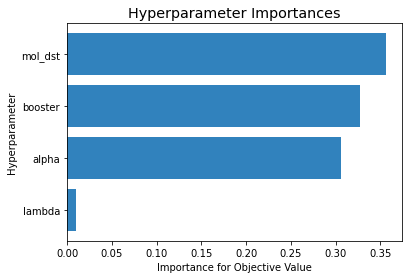

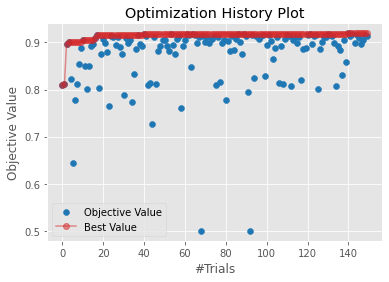

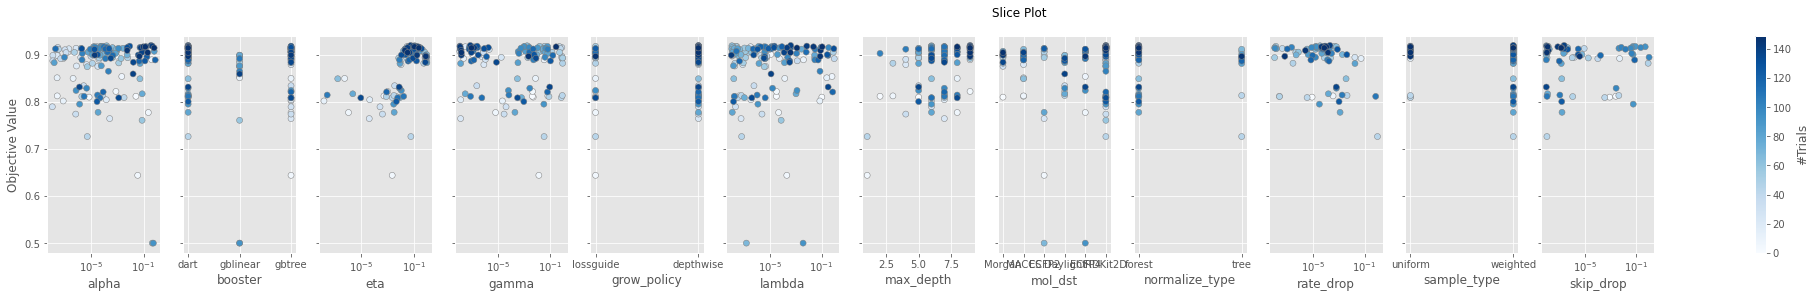

In [8]:
v1 = oviz.plot_param_importances(study)
v2 = oviz.plot_optimization_history(study)
v3 = oviz.plot_slice(study)

def fig_name(name):
    return(optuna_dir + "output/" + "{}.{}_{}.{}.{}_{}.pdf".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year, name))

v1.figure.savefig(fig_name("HyperparameterImportance"))
v2.figure.savefig(fig_name("OptimizationHistory"))

Finally, I train a new model based on the best trial.

In [9]:
# train new model based on the best trial
best_xgb_model = xgb.Booster()
best_xgb_model.load_model(model_dir + "xgboost_model_{}.json".format(best_trial.number))

# save model for this loop
best_xgb_model.save_model(model_dir + "best_xgboost_model.json")

I visualize the best tree with the `matplotlib` library. This requires `pip install graphviz`, see [this tutorial](https://www.datacamp.com/community/tutorials/xgboost-in-python).

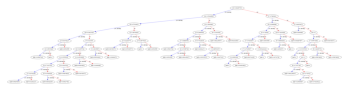

In [10]:
xgb.plot_tree(best_xgb_model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig(fig_name("BestXGBoostTree"), dpi = 900)

I also plot feature importance.

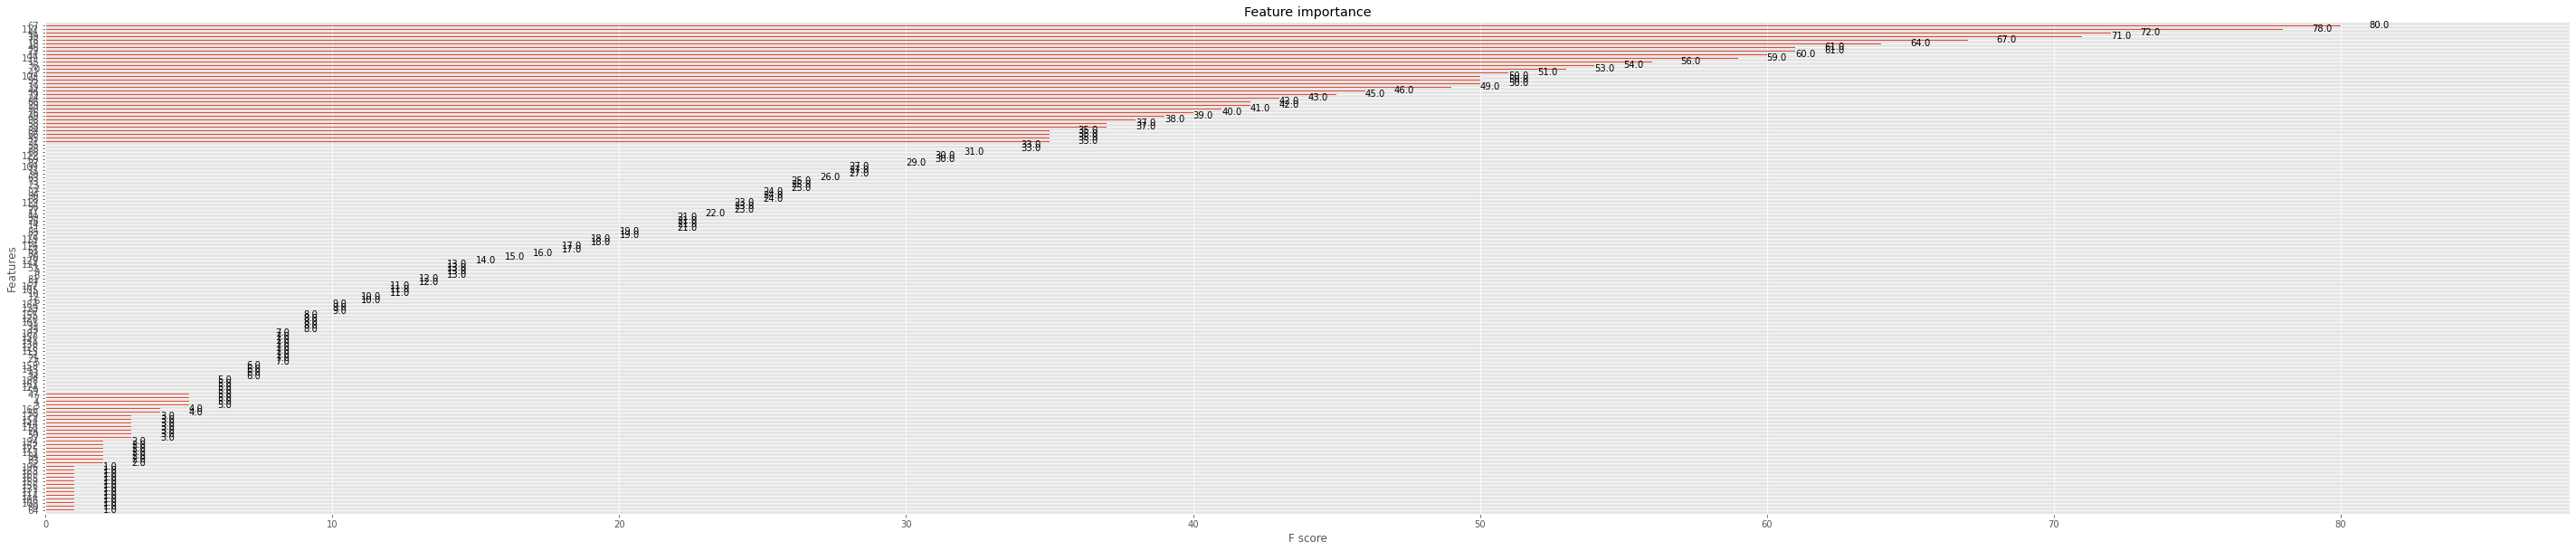

In [11]:
xgb.plot_importance(best_xgb_model)
plt.rcParams['figure.figsize'] = [10, 30]
plt.savefig(fig_name("FeatureImportance"), dpi = 900)

Now, I evaluate on the independent test set.

In [12]:
# convert fingerprint
test_converter = MolConvert(src = 'SMILES', dst = best_trial.params['mol_dst'])
test_features = pd.DataFrame([test_converter(x) for x in test['Drug']])
dtest = xgb.DMatrix(test_features, label = test['Y'])

Test set evaluation.

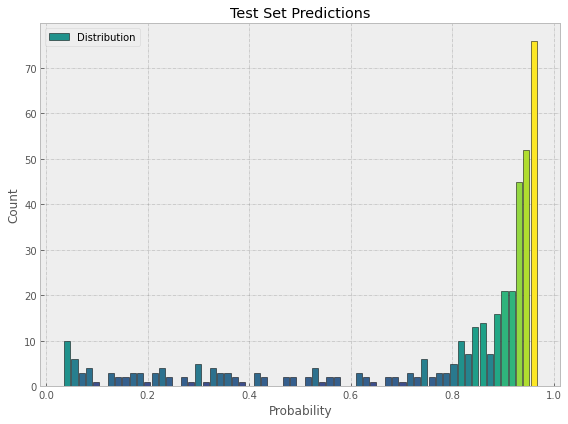

In [13]:
# evaluate on test set
y_pred_test = best_xgb_model.predict(dtest)

# set style
with plt.style.context('bmh'):

    # create figure
    fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

    # add grid lines
    axs.grid(b = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.6)

    # create histogram
    max_value = np.max(y_pred_test)
    bin_width = 0.015
    nbins = np.ceil(max_value/bin_width)
    N, bins, patches = axs.hist(y_pred_test, bins = int(nbins), rwidth = 0.85, edgecolor = "black")

    # set color
    fracs = ((N**(1 / 3))/N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    # add labels
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.legend(['Distribution'])
    plt.title("Test Set Predictions")

# show plot
plt.savefig(fig_name("TestSetPredictions"), dpi = 900)

Finally, evaluate the results of the predictions.

In [14]:
# append predictions to test set object
predictions[name] = y_pred_test
predictions_list.append(predictions)

# evaluate predictions on test set
# print(group.evaluate_many(predictions_list))
group.evaluate(predictions_list[0])

{'bbb_martins': {'roc-auc': 0.89}}

Next, I plot the ROC curve on the independent test set.

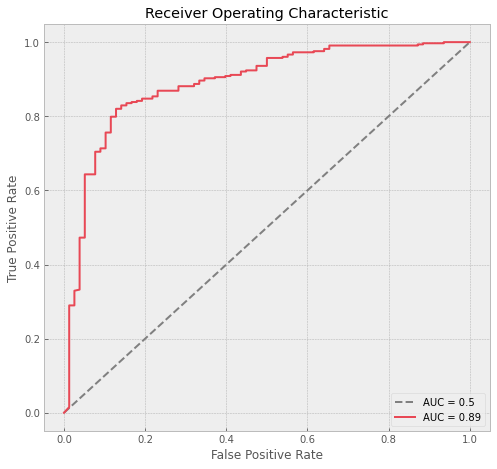

In [15]:
# get FPR and TPR
fpr, tpr, _ = metrics.roc_curve(test['Y'],  y_pred_test)
auc = metrics.roc_auc_score(test['Y'],  y_pred_test)

# create ROC curve
# see plt.style.available for available styles
with plt.style.context('bmh'):
    plt.figure(figsize = (8, 7.5))
    plt.plot([0, 1], [0, 1], label = "AUC = 0.5", color = "gray", linestyle = '--', linewidth = 2)
    plt.plot(fpr, tpr, label = "AUC = " + str(round(auc, 3)), color = "#E84855", linewidth = 2)
    plt.title("Receiver Operating Characteristic")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc = 4)

# save figure
plt.savefig(fig_name("TestSetROC"), dpi = 900)

In [17]:
print("AUC: " + str(auc))

AUC: 0.8898921200750467
